<a href="https://www.kaggle.com/code/jaksanders/electric-load-forecasting-with-deep-learning?scriptVersionId=146642045" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Short-term residential load forecasting with Deep Learning

* Use London Households SmartMeter Data
* Data evaluation, cleanup and pre-processing for machine learning
* Exploratory data analysis and visualization
* Create a benchmark persistence model to evaluate our deep learning models against
* Build, Train and Evaluate the following algorithms against the benchmark
* Multi Layer Perceptron, RNN, LSTM, GRU, CNN
* Calculate the financial impact of the most accurate model for a electric distribution network operator


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import IPython
import IPython.display
import glob
import time
import pickle
import warnings
warnings.filterwarnings("ignore")
randomState = 42 # tip of the cap to Douglas Adams

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-o

# Load Data

## Load half-hourly electric usage data
...for ~5k smart meters in London
[SmartMeter Energy Consumption Data in London Households](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households)

In [2]:
# load half-hourly electric usage data
# takes about four minutes, need to find somerthing faster like Dask?
# https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households
# Get CSV files list from a folder
path = '/kaggle/input/smart-meters-in-london/halfhourly_dataset/halfhourly_dataset'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
start_time = time.time()
df_list = (pd.read_csv(file, parse_dates=["tstp"]) for file in csv_files)
print('%s seconds' % (time.time() - start_time))

# Concatenate all DataFrames
start_time = time.time()
d = pd.concat(df_list, ignore_index=True)
print('%s seconds' % (time.time() - start_time))

0.0001251697540283203 seconds
280.6213390827179 seconds


In [3]:
d.describe()

LCLid                 tstp energy(kWh/hh)
count   167817021            167817021      167817021
unique       5566                40405           9611
top     MAC000147  2012-11-19 00:30:00             0 
freq        39725                 5531        2001094
first         NaN  2011-11-23 09:00:00            NaN
last          NaN  2014-02-28 00:00:00            NaN

## Load hourly weather data

In [4]:
# load hourly weather data
# https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households
weatherData = pd.read_csv('/kaggle/input/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=["time"])

In [5]:
weatherData.describe()

visibility   windBearing   temperature      dewPoint      pressure  \
count  21165.000000  21165.000000  21165.000000  21165.000000  21152.000000   
mean      11.166485    195.685897     10.471486      6.530501   1014.125153   
std        3.099337     90.629453      5.781904      5.041965     11.388337   
min        0.180000      0.000000     -5.640000     -9.980000    975.740000   
25%       10.120000    121.000000      6.470000      2.820000   1007.430000   
50%       12.260000    217.000000      9.930000      6.570000   1014.780000   
75%       13.080000    256.000000     14.310000     10.330000   1022.050000   
max       16.090000    359.000000     32.400000     19.880000   1043.320000   

       apparentTemperature     windSpeed      humidity  
count         21165.000000  21165.000000  21165.000000  
mean              9.230338      3.905215      0.781829  
std               6.940919      2.026854      0.140369  
min              -8.880000      0.040000      0.230000  
25%               3.900000      2.420000      0.700000  
50%               9.360000      3.680000      0.810000  
75%              14.320000      5.070000      0.890000  
max              32.420000     14.800000      1.000000

In [6]:
weatherData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   visibility           21165 non-null  float64       
 1   windBearing          21165 non-null  int64         
 2   temperature          21165 non-null  float64       
 3   time                 21165 non-null  datetime64[ns]
 4   dewPoint             21165 non-null  float64       
 5   pressure             21152 non-null  float64       
 6   apparentTemperature  21165 non-null  float64       
 7   windSpeed            21165 non-null  float64       
 8   precipType           21165 non-null  object        
 9   icon                 21165 non-null  object        
 10  humidity             21165 non-null  float64       
 11  summary              21165 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 1.9+ MB


# Data pre-processing and cleaning

## Weather data: convert text attributes to string datatype

In [7]:
weatherData = weatherData.astype({'precipType':'string', 'icon':'string', 'summary':'string'})

In [8]:
from pandas_profiling import ProfileReport

profile = ProfileReport(weatherData, tsmode=True, sortby="time")
profile.to_file('weatherData profile_report.html')
# profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Identify and remove weather records not exactly on the hour

In [9]:
# inspect and remove records not exactly on the hour
offRecs = weatherData.query("time.dt.minute != 0 or time.dt.second != 0")
print('Records not exactly on the half-hour:\n ', offRecs)

Records not exactly on the half-hour:
  Empty DataFrame
Columns: [visibility, windBearing, temperature, time, dewPoint, pressure, apparentTemperature, windSpeed, precipType, icon, humidity, summary]
Index: []


In [10]:
# select weather data features of interest
weatherUpsample = weatherData[['time','temperature', 'dewPoint']].copy()
# weatherUpsample = weatherData[['time','temperature', 'dewPoint', 'pressure', 'humidity']].copy()
# pressure and humidity removed due to permutation feature importance
weatherUpsample = weatherUpsample.sort_values(by=['time'])
print(weatherUpsample.info())
print(weatherUpsample.describe())
print(weatherUpsample)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21165 entries, 312 to 20276
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         21165 non-null  datetime64[ns]
 1   temperature  21165 non-null  float64       
 2   dewPoint     21165 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 661.4 KB
None
        temperature      dewPoint
count  21165.000000  21165.000000
mean      10.471486      6.530501
std        5.781904      5.041965
min       -5.640000     -9.980000
25%        6.470000      2.820000
50%        9.930000      6.570000
75%       14.310000     10.330000
max       32.400000     19.880000
                     time  temperature  dewPoint
312   2011-11-01 00:00:00        13.49     11.48
313   2011-11-01 01:00:00        12.73     11.58
314   2011-11-01 02:00:00        13.65     12.14
315   2011-11-01 03:00:00        14.13     12.24
316   2011-11-01 04:00:00   

## Upsample weather data to match half-houly sampling rate of load data

In [11]:
# get the index set up to support the resamle operation
weatherUpsample.set_index('time', inplace=True)
weatherUpsample.index.rename('time', inplace=True)

start_time = time.time()
weatherUpsample = weatherUpsample.resample('30Min').mean()

# upsample 
weatherUpsample['temperature'] = weatherUpsample['temperature'].interpolate()
weatherUpsample['dewPoint'] = weatherUpsample['dewPoint'].interpolate()
# weatherUpsample['pressure'] = weatherUpsample['pressure'].interpolate()
# weatherUpsample['humidity'] = weatherUpsample['humidity'].interpolate()

print('%s seconds' % (time.time() - start_time))

weatherUpsample = weatherUpsample.reset_index(names='DateTime')
print(weatherUpsample.info())
print(weatherUpsample.describe())
print(weatherUpsample)

0.0315394401550293 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42333 entries, 0 to 42332
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DateTime     42333 non-null  datetime64[ns]
 1   temperature  42333 non-null  float64       
 2   dewPoint     42333 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 992.3 KB
None
        temperature      dewPoint
count  42333.000000  42333.000000
mean      10.471414      6.530646
std        5.775688      5.037766
min       -5.640000     -9.980000
25%        6.475000      2.830000
50%        9.935000      6.575000
75%       14.320000     10.325000
max       32.400000     19.880000
                 DateTime  temperature  dewPoint
0     2011-11-01 00:00:00       13.490    11.480
1     2011-11-01 00:30:00       13.110    11.530
2     2011-11-01 01:00:00       12.730    11.580
3     2011-11-01 01:30:00       13.190    11.860
4  

In [12]:
# save weather data so we can don't have to do pre-processing again
weatherUpsample.to_csv('/kaggle/working/WeatherDataFinal.csv',index=False)

In [13]:
# load pre-processed weather data
weatherUpsample = pd.read_csv('/kaggle/working/WeatherDataFinal.csv', parse_dates=["DateTime"])
weatherUpsample

DateTime  temperature  dewPoint
0     2011-11-01 00:00:00       13.490    11.480
1     2011-11-01 00:30:00       13.110    11.530
2     2011-11-01 01:00:00       12.730    11.580
3     2011-11-01 01:30:00       13.190    11.860
4     2011-11-01 02:00:00       13.650    12.140
...                   ...          ...       ...
42328 2014-03-31 20:00:00       13.620     7.910
42329 2014-03-31 20:30:00       13.325     7.935
42330 2014-03-31 21:00:00       13.030     7.960
42331 2014-03-31 21:30:00       12.770     7.965
42332 2014-03-31 22:00:00       12.510     7.970

[42333 rows x 3 columns]

In [14]:
print(weatherUpsample)


                 DateTime  temperature  dewPoint
0     2011-11-01 00:00:00       13.490    11.480
1     2011-11-01 00:30:00       13.110    11.530
2     2011-11-01 01:00:00       12.730    11.580
3     2011-11-01 01:30:00       13.190    11.860
4     2011-11-01 02:00:00       13.650    12.140
...                   ...          ...       ...
42328 2014-03-31 20:00:00       13.620     7.910
42329 2014-03-31 20:30:00       13.325     7.935
42330 2014-03-31 21:00:00       13.030     7.960
42331 2014-03-31 21:30:00       12.770     7.965
42332 2014-03-31 22:00:00       12.510     7.970

[42333 rows x 3 columns]


In [15]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   LCLid           object        
 1   tstp            datetime64[ns]
 2   energy(kWh/hh)  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 3.8+ GB


In [16]:
# utility function to nicely format variable names and memory they are consuming
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

## Convert smart meter usage datatype to float

In [17]:
# ~1 minute
start_time = time.time()
d.iloc[:, 2] = pd.to_numeric(d.iloc[:, 2], errors='coerce')
print('%s seconds' % (time.time() - start_time))

# rename usage column for easier reference
d.rename(columns={d.columns[2]: 'KWHperHH'}, inplace=True)
d.info()

54.165284872055054 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   LCLid     object        
 1   tstp      datetime64[ns]
 2   KWHperHH  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.8+ GB


In [18]:
# set timestamp as the index
start_time = time.time()
d.set_index('tstp')
print('%s seconds' % (time.time() - start_time))

6.134496450424194 seconds


## Identify and handle duplicates in the smart meter data

In [19]:
# about 1.5 minutes
start_time = time.time()
dupes = d[d.duplicated()]
print('dupes', dupes)
print('dupes.index', dupes.index)
d.drop(index=dupes.index, inplace=True)
print('%s seconds' % (time.time() - start_time))

dupes Empty DataFrame
Columns: [LCLid, tstp, KWHperHH]
Index: []
dupes.index Int64Index([], dtype='int64')
102.36457681655884 seconds


In [20]:
# set index for the usage data to the timestamp column.  Is this necessary?  Can't remember why
start_time = time.time()
d.set_index('tstp')
d.info()
print('%s seconds' % (time.time() - start_time))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   LCLid     object        
 1   tstp      datetime64[ns]
 2   KWHperHH  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.8+ GB
4.797167539596558 seconds


In [21]:
# check what is gobbling RAM
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                             d: 12.8 GiB
                   weatherData:  5.5 MiB
                             _: 992.3 KiB
               weatherUpsample: 992.3 KiB
                           _13: 992.3 KiB
                           ___:  1.3 KiB
                            _3:  1.3 KiB
                 ProfileReport:  1.2 KiB
                     csv_files:  1.1 KiB
                            __: 1011.0 B


# Visualize smart meter dataset to analyze for quality, completenes and othe insights

## grab a random sample of 2% of meters for visualization and analysis

In [22]:
rng = np.random.default_rng(randomState)
# random_state = np.random.RandomState(randomState)
sampleMeters = rng.choice(d.LCLid.unique(), size=int(len(d.LCLid.unique())*0.02), replace=False)
print('sampleMeters:\n', sampleMeters)
sample = d[d['LCLid'].isin(sampleMeters)]
print('sample:\n', sample)
print(sample.describe())
# print(sample.info())

sampleMeters:
 ['MAC003787' 'MAC004997' 'MAC000079' 'MAC001558' 'MAC001656' 'MAC001938'
 'MAC003313' 'MAC001152' 'MAC002826' 'MAC000272' 'MAC000133' 'MAC001726'
 'MAC004462' 'MAC003604' 'MAC001933' 'MAC003085' 'MAC004775' 'MAC005467'
 'MAC002659' 'MAC005353' 'MAC003411' 'MAC005264' 'MAC000875' 'MAC001330'
 'MAC002750' 'MAC003007' 'MAC003705' 'MAC003049' 'MAC003468' 'MAC004190'
 'MAC002703' 'MAC000477' 'MAC000020' 'MAC003603' 'MAC001982' 'MAC003471'
 'MAC000878' 'MAC004084' 'MAC001267' 'MAC004947' 'MAC001665' 'MAC005543'
 'MAC001762' 'MAC003512' 'MAC000071' 'MAC000089' 'MAC005269' 'MAC004873'
 'MAC000118' 'MAC001493' 'MAC003876' 'MAC005095' 'MAC002583' 'MAC005132'
 'MAC004659' 'MAC004419' 'MAC002866' 'MAC002854' 'MAC001995' 'MAC004157'
 'MAC002860' 'MAC004271' 'MAC000407' 'MAC002805' 'MAC004927' 'MAC001184'
 'MAC001159' 'MAC002448' 'MAC003486' 'MAC001054' 'MAC003291' 'MAC005448'
 'MAC002654' 'MAC003222' 'MAC004803' 'MAC004460' 'MAC003087' 'MAC000214'
 'MAC003040' 'MAC000183' 'MAC000653'

In [23]:
sample.to_csv('/kaggle/working/sampleMeters.csv',index=False)

In [24]:
sample = pd.read_csv('/kaggle/working/sampleMeters.csv', parse_dates=["tstp"])
sample

LCLid                tstp  KWHperHH
0        MAC001330 2012-05-17 11:00:00     0.157
1        MAC001330 2012-05-17 11:30:00     0.192
2        MAC001330 2012-05-17 12:00:00     0.675
3        MAC001330 2012-05-17 12:30:00     0.418
4        MAC001330 2012-05-17 13:00:00     1.446
...            ...                 ...       ...
3410959  MAC005448 2014-02-27 22:00:00     0.144
3410960  MAC005448 2014-02-27 22:30:00     0.086
3410961  MAC005448 2014-02-27 23:00:00     0.053
3410962  MAC005448 2014-02-27 23:30:00     0.058
3410963  MAC005448 2014-02-28 00:00:00     0.048

[3410964 rows x 3 columns]

## Heatmap to visualize meter read coverage and completeness

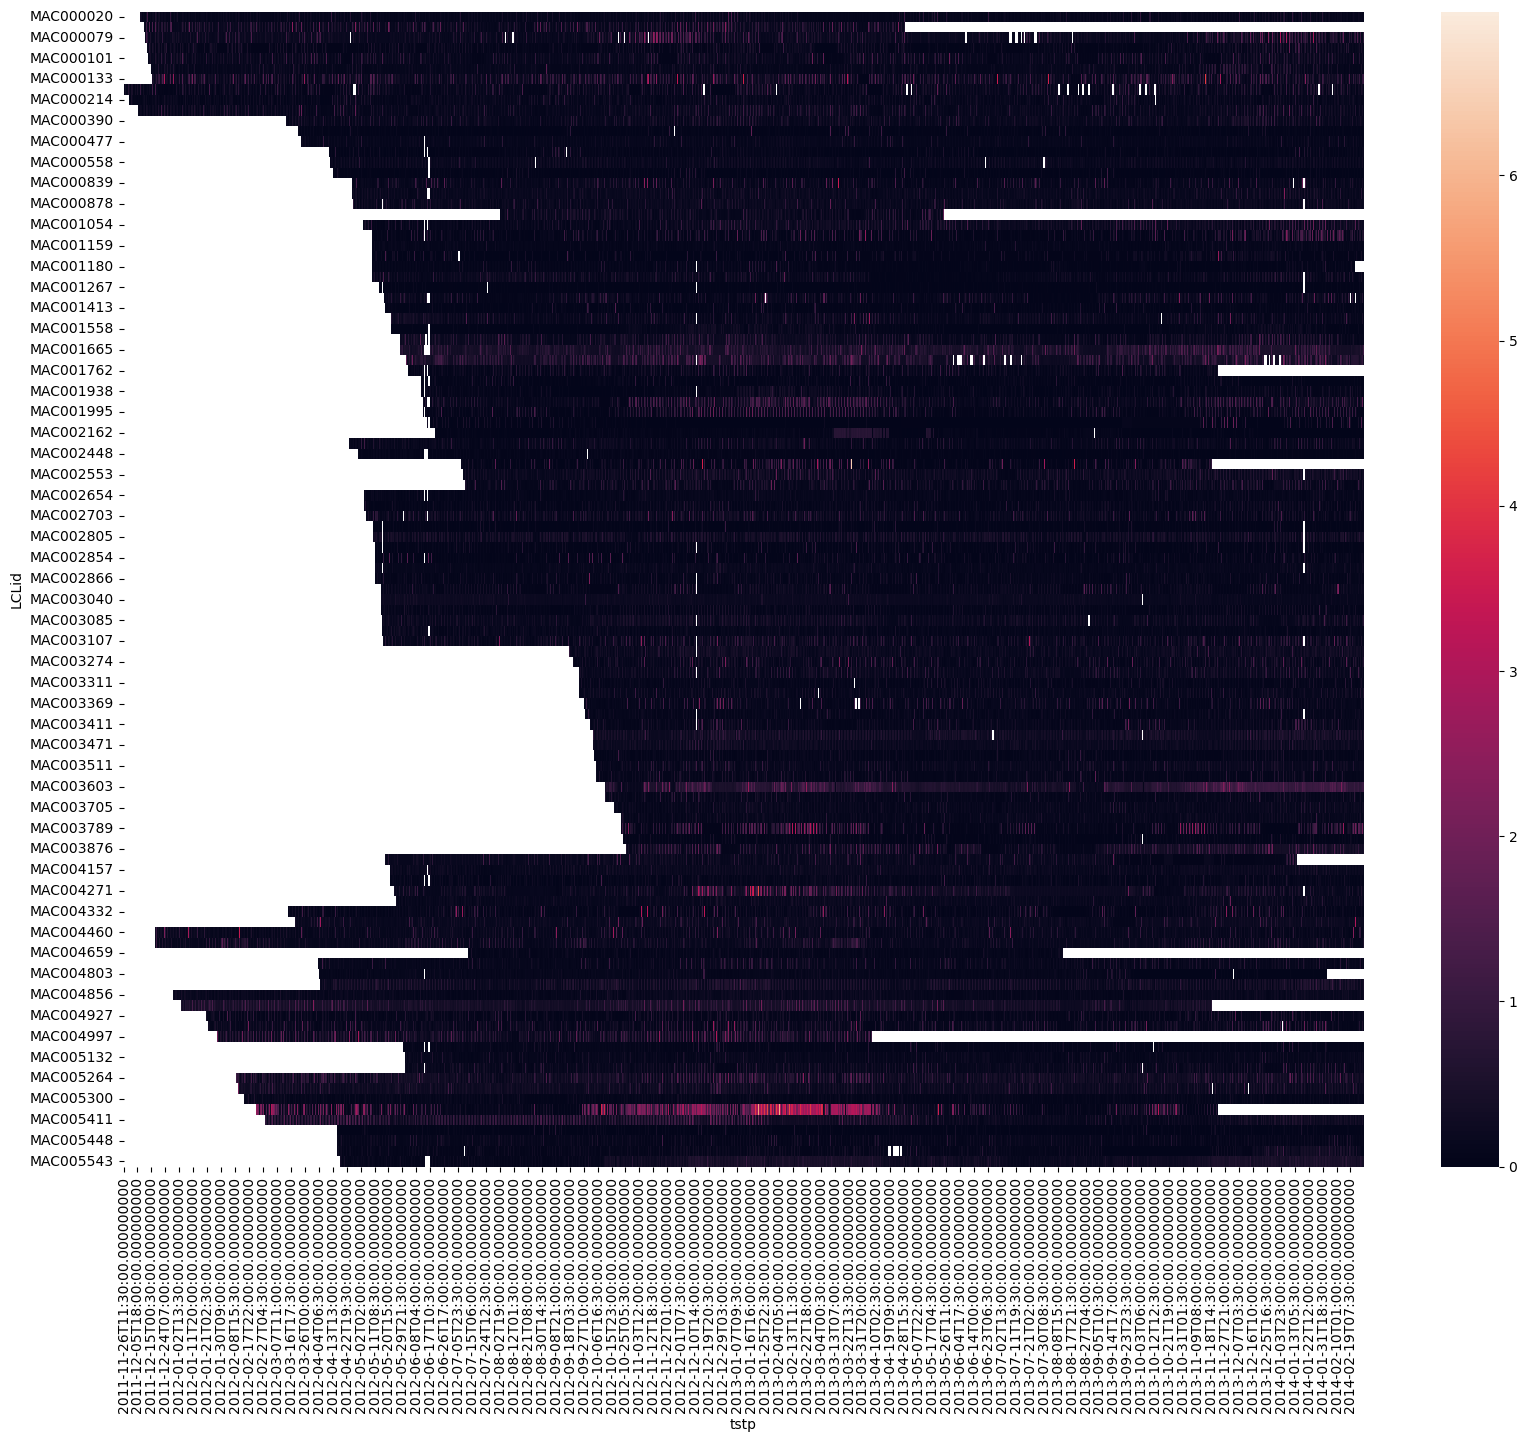

In [25]:
# visualize meter read coverage and completeness
# using a random sample of 2% of meters
plt.subplots(figsize=(20,15))
pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='KWHperHH')
sns.heatmap(pivot_table)
plt.savefig('meter data heatmap.png', format='png')

Observations from Heatmap...
* several houses start producing load part-way through the period
    - eg MAC004221, MAC004248
    
    
* several houses stop producing part-way through the period
    - eg MAC004226, MAC004257
    

* most houses have at least one "gap" in their data (visible as white lines)


* several houses stand out as having significantly higher average load than others
    - eg MAC004225, MAC004249

## identify and remove smart meter readings not exactly on the half-hour

In [26]:
# identify and remove records not exactly on the half-hour
start_time = time.time()

offRecs = d.query("tstp.dt.minute not in (0,30) or tstp.dt.second != 0")
# aggLoad["DateTime"].dt.hour > 30
print('Records not exactly on the half-hour:\n ', offRecs)
print(offRecs.info())

# delete records not exactly on the half-hour
d.drop(offRecs.index, inplace=True)

print('%s seconds' % (time.time() - start_time))

offRecs = d.query("tstp.dt.minute not in (0,30) or tstp.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)

Records not exactly on the half-hour:
                 LCLid                tstp  KWHperHH
18051      MAC000047 2012-12-18 15:13:44       NaN
52485      MAC000362 2012-12-18 15:15:14       NaN
86881      MAC000385 2012-12-18 15:15:16       NaN
120772     MAC000486 2012-12-18 15:15:42       NaN
138889     MAC000507 2012-12-18 15:15:45       NaN
...              ...                 ...       ...
167658239  MAC005035 2012-12-18 15:14:33       NaN
167694593  MAC005048 2012-12-18 15:14:35       NaN
167730712  MAC005229 2012-12-18 15:14:41       NaN
167763454  MAC005448 2012-12-18 15:16:23       NaN
167796074  MAC005508 2012-12-18 15:16:29       NaN

[5560 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5560 entries, 18051 to 167796074
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   LCLid     5560 non-null   object        
 1   tstp      5560 non-null   datetime64[ns]
 2   KWHperHH  0 non-nul

In [27]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167811461 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   LCLid     object        
 1   tstp      datetime64[ns]
 2   KWHperHH  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.0+ GB


In [28]:
# check what is gobbling RAM
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                             d: 14.1 GiB
                             _: 266.7 MiB
                        sample: 266.7 MiB
                           _24: 266.7 MiB
                   pivot_table: 33.5 MiB
                   weatherData:  5.5 MiB
                            __: 992.3 KiB
               weatherUpsample: 992.3 KiB
                           _13: 992.3 KiB
                            _3:  1.3 KiB


## Fill gaps in the smart meter data using interpolation

Our heatmap above shows lots of gaps (small white vertical lines), and we'll fill those gaps using interpolation

### First step of filling these gaps is to create NaN records where records are missing

Then we can fill these gas with interpolation

In [29]:
# First step of interpolation is to create NaN records where records are missing
# about 2 minutes
d.sort_values(by=['tstp'], inplace=True)
d.set_index('tstp', inplace=True)
d.index.rename('tstp', inplace=True)

start_time = time.time()
# resample to create NaN records where records are missing
d = d.groupby('LCLid')\
                .resample('30Min')\
                .mean()

# fill the gaps with interpolation
d['KWHperHH'] = d['KWHperHH'].interpolate()
d.reset_index(inplace=True)

print('%s seconds' % (time.time() - start_time))

148.98000693321228 seconds


## Check the meter data heatmap to see if gaps have been filled

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168268119 entries, 0 to 168268118
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   LCLid     object        
 1   tstp      datetime64[ns]
 2   KWHperHH  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.8+ GB


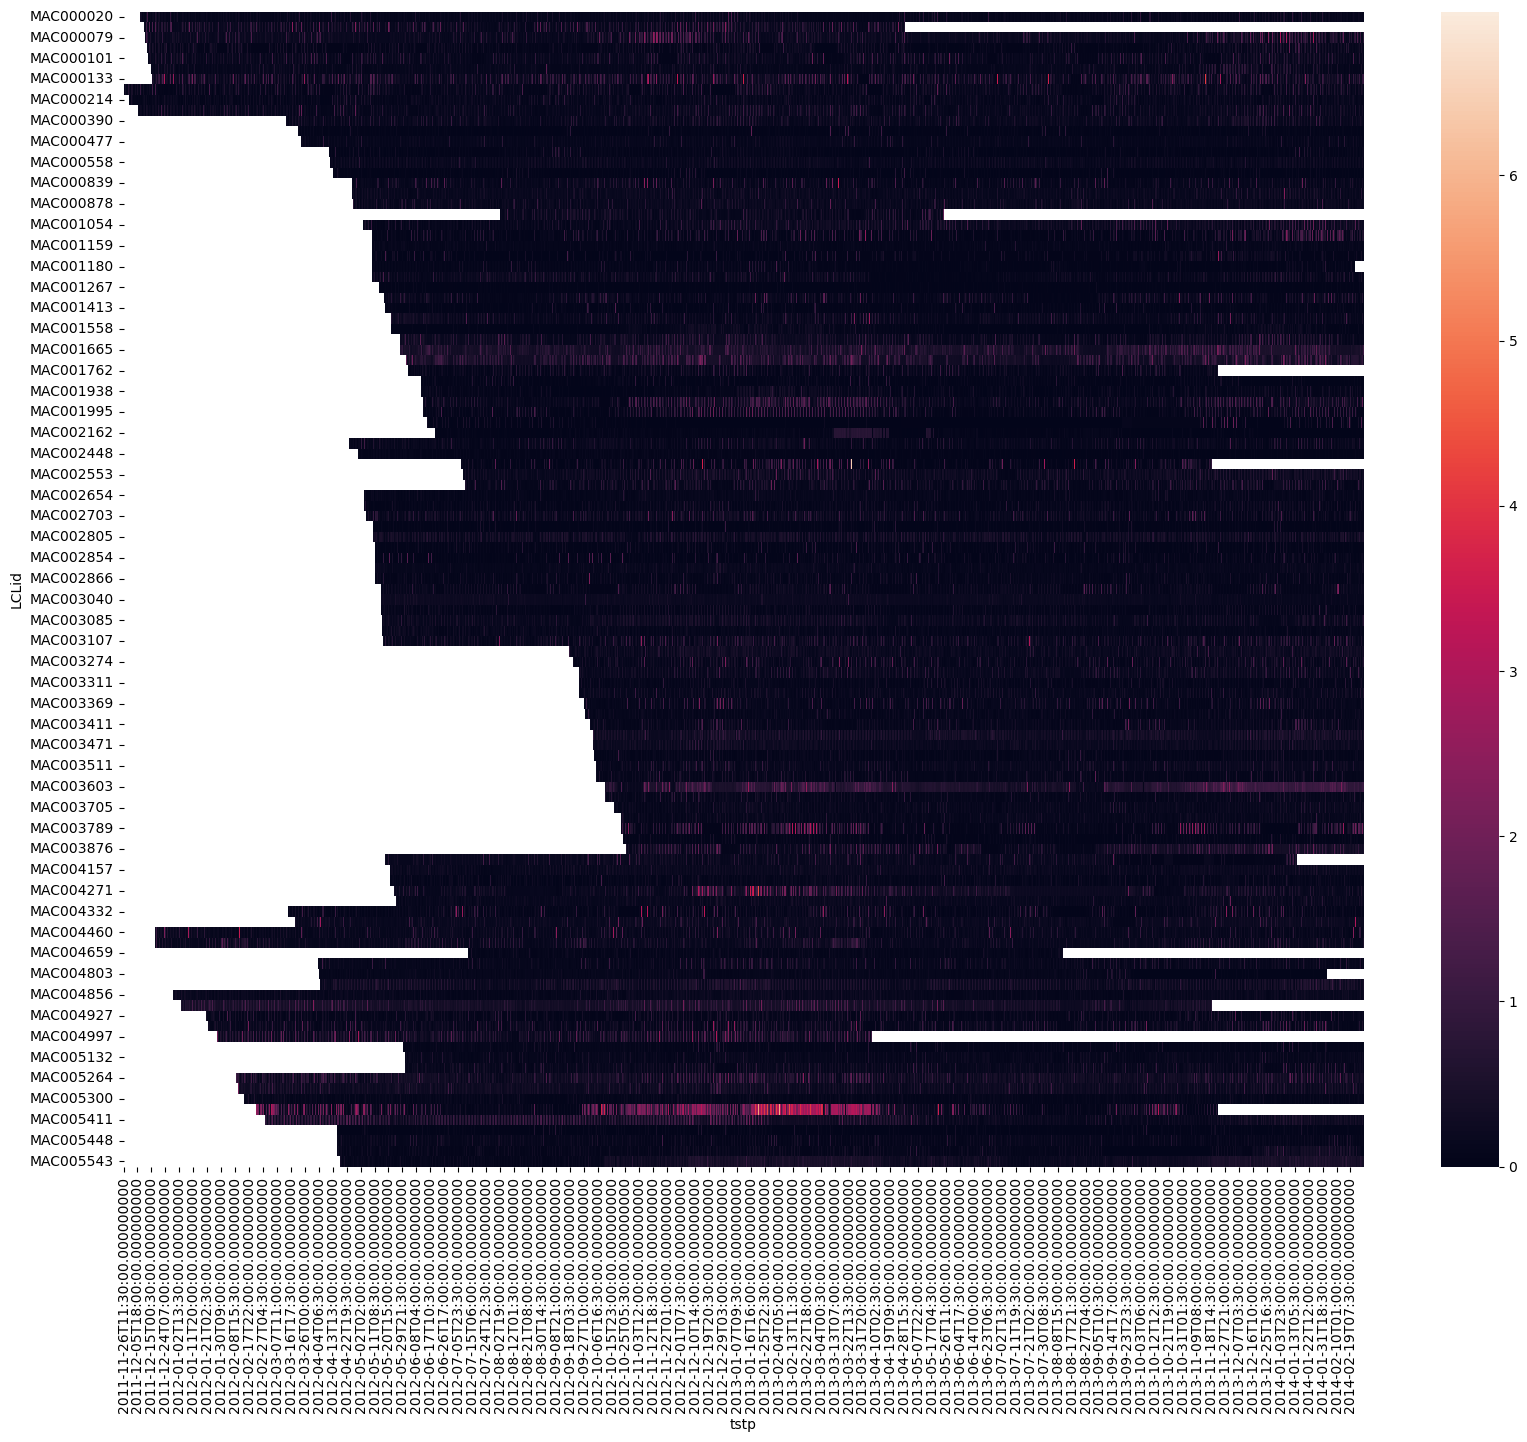

In [30]:
# visualize after interpolating missing values
d.info()
sample = d[d['LCLid'].isin(sampleMeters)]
pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='KWHperHH')
plt.subplots(figsize=(20,15))

sns.heatmap(pivot_table)
plt.savefig('meter data heatmap gaps filled.png', format='png')

## Visualize zeros in the dataset using heatmap

I'm always curious to understand zeros in a dataset, and whether they are legitimate zero values, or indicate a data quality problem.

7.7117486000061035 seconds


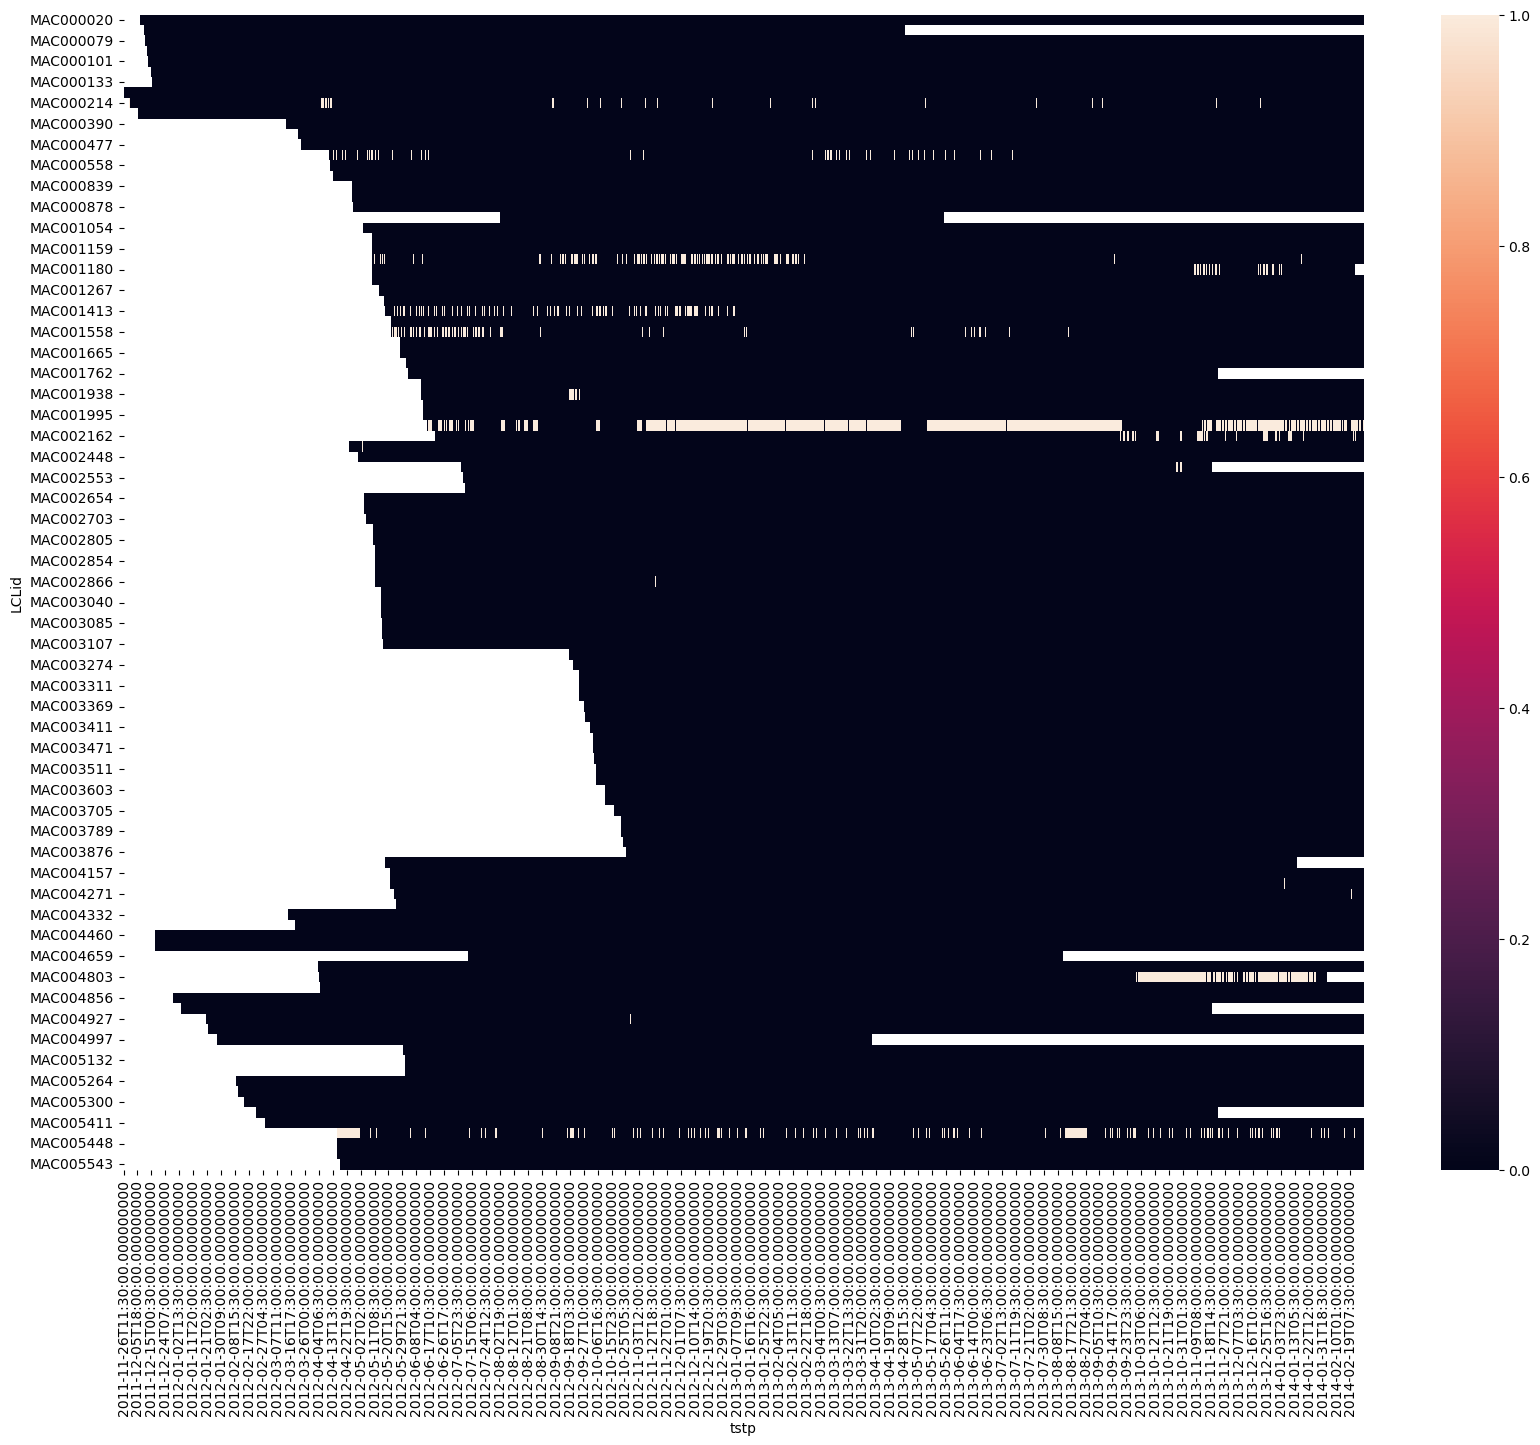

In [31]:
# visualize zeros in the dataset
start_time = time.time()
sample = d[d['LCLid'].isin(sampleMeters)]
sample['ZeroKWHperHH'] = sample['KWHperHH'] == 0
pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='ZeroKWHperHH')
print('%s seconds' % (time.time() - start_time))
plt.subplots(figsize=(20,15))

sns.heatmap(pivot_table)
plt.savefig('meter data heatmap zeros.png', format='png')

In [32]:
# take a snapshot of data
# takes about 11 minutes
start_time = time.time()
d.to_csv('/kaggle/working/MeterDataFinal.csv',index=False)
print('%s seconds' % (time.time() - start_time))

692.2802875041962 seconds


### Obervation

There are a handful of households that account all the zero value meter reads: MAC004233, MAC004226, MAC004267

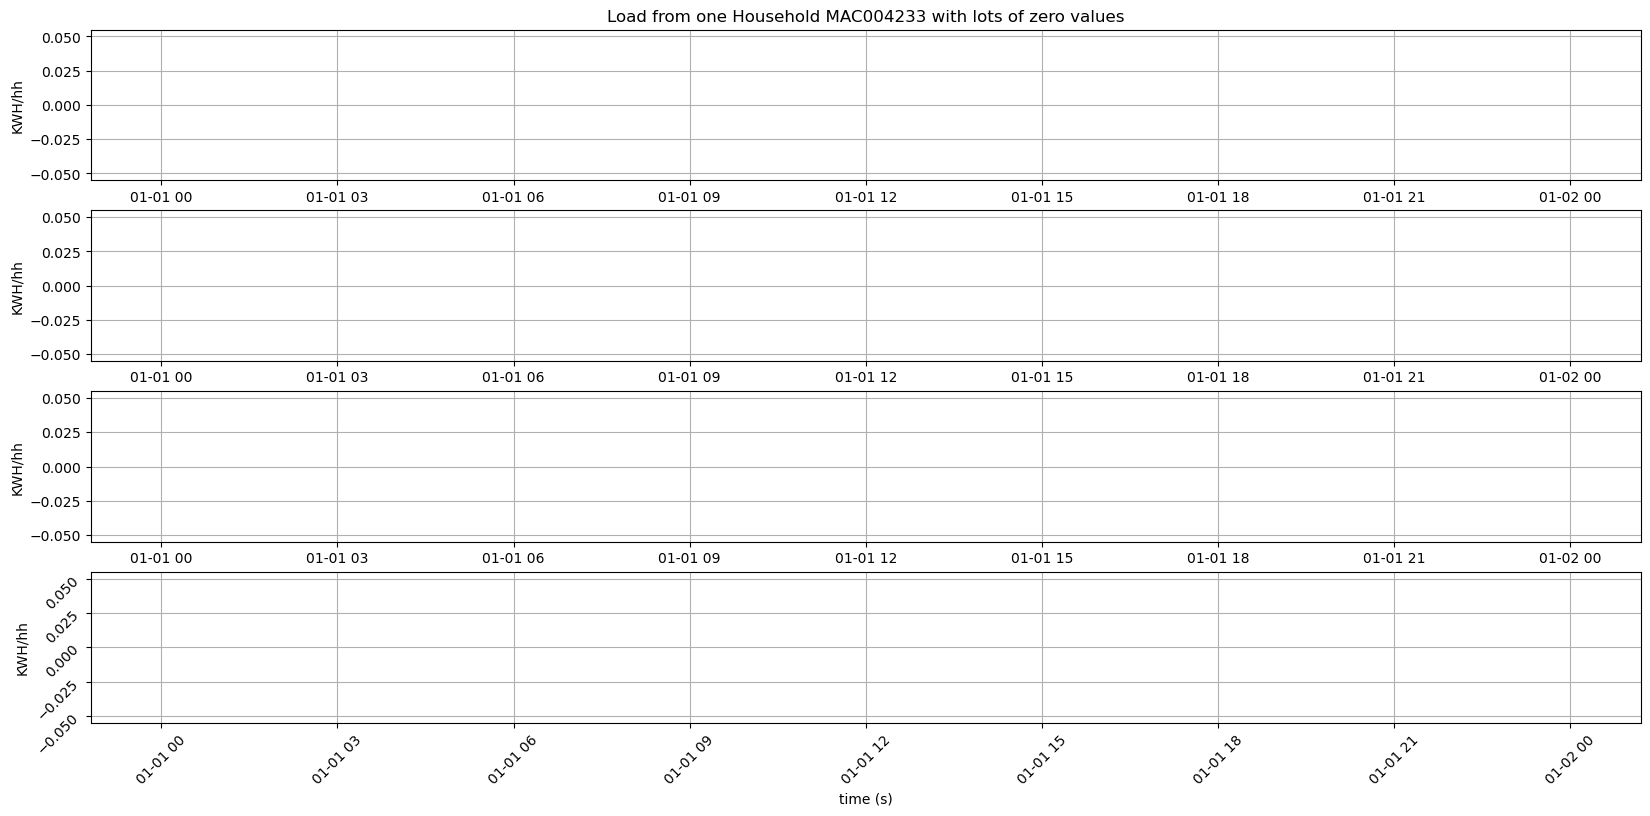

In [33]:
# investigate the meters with zero reads
MAC005127 = sample.query("LCLid == 'MAC005127'")

fig, ax = plt.subplots(4,figsize=(20,9))

# plot whole ~2 years
ax[0].plot(MAC005127.tstp, MAC005127.KWHperHH)
ax[0].plot(MAC005127.tstp, MAC005127.ZeroKWHperHH)
ax[0].set(ylabel='KWH/hh',
       title='Load from one Household MAC004233 with lots of zero values')
plt.tick_params(rotation=45)
ax[0].grid()

# zoom in
ax[1].plot(MAC005127.tstp[11000:15000], MAC005127.KWHperHH[11000:15000])
ax[1].plot(MAC005127.tstp[11000:15000], MAC005127.ZeroKWHperHH[11000:15000])
ax[1].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[1].grid()

# zoom in more...
ax[2].plot(MAC005127.tstp[13000:13500], MAC005127.KWHperHH[13000:13500])
ax[2].plot(MAC005127.tstp[13000:13500], MAC005127.ZeroKWHperHH[13000:13500])
ax[2].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[2].grid()

# zoom in to a different part of the series...
ax[3].plot(MAC005127.tstp[25000:25500], MAC005127.KWHperHH[25000:25500])
ax[3].plot(MAC005127.tstp[25000:25500], MAC005127.ZeroKWHperHH[25000:25500])
ax[3].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[3].grid()

fig.savefig("MAC005127.png")
plt.show()

### Observation:
The zeros for MAC004233 seem legit - leaving them in

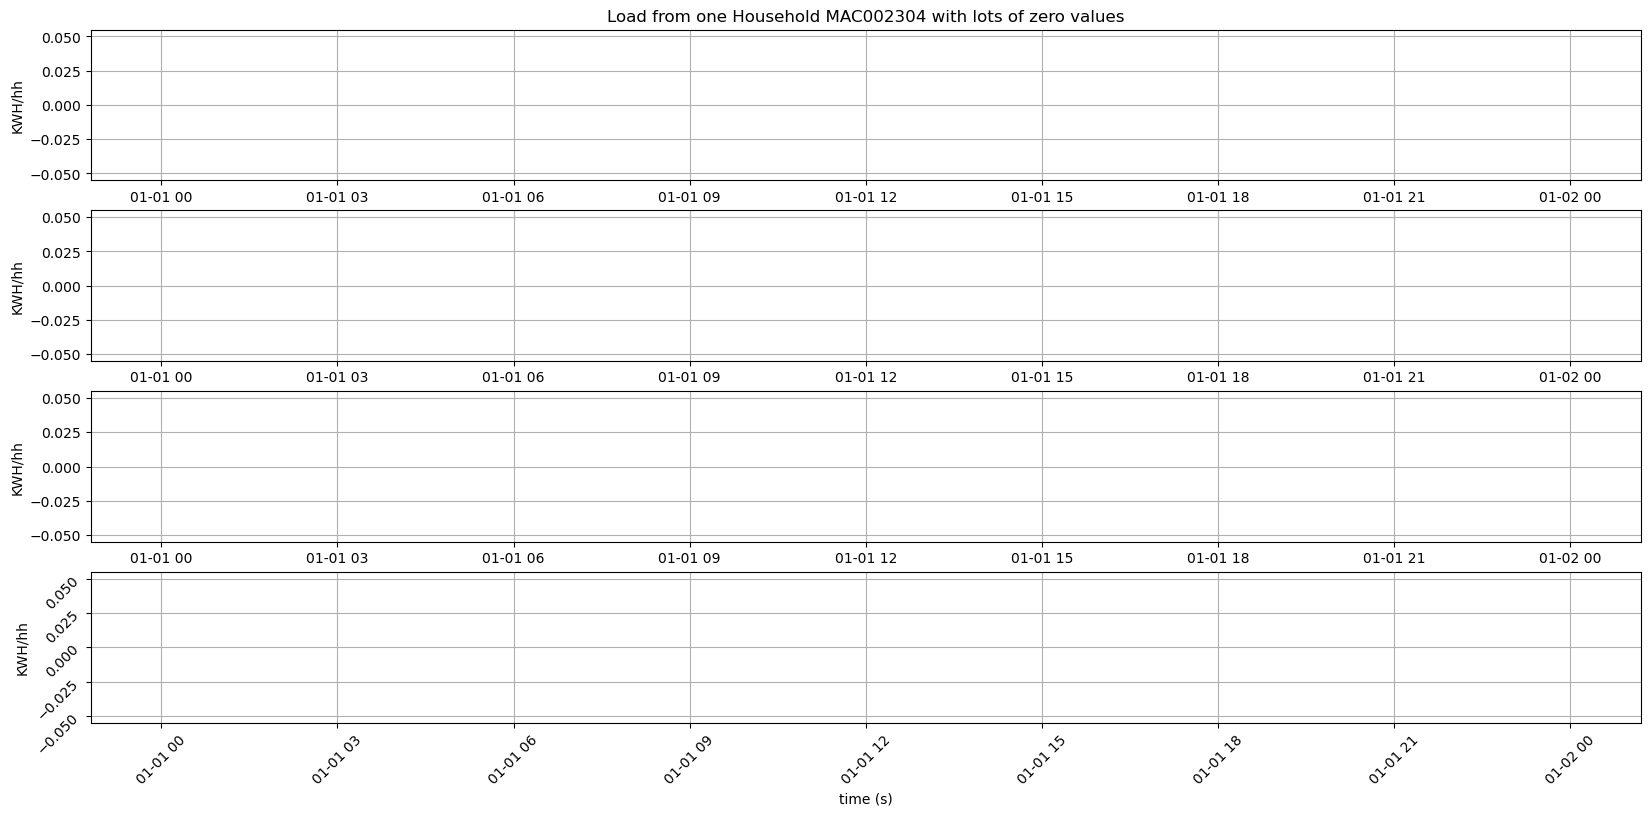

In [34]:
# investigate the meters with zero reads
MAC002304 = sample.query("LCLid == 'MAC002304'")
fig, ax = plt.subplots(4,figsize=(20,9))

# plot whole ~2 years
ax[0].plot(MAC002304.tstp, MAC002304.KWHperHH)
ax[0].plot(MAC002304.tstp, MAC002304.ZeroKWHperHH)
ax[0].set(ylabel='KWH/hh',
       title='Load from one Household MAC002304 with lots of zero values')
plt.tick_params(rotation=45)
ax[0].grid()

# zoom in
ax[1].plot(MAC002304.tstp[17000:21000], MAC002304.KWHperHH[17000:21000])
ax[1].plot(MAC002304.tstp[17000:21000], MAC002304.ZeroKWHperHH[17000:21000])
ax[1].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[1].grid()

# zoom in more...
ax[2].plot(MAC002304.tstp[19300:19800], MAC002304.KWHperHH[19300:19800])
ax[2].plot(MAC002304.tstp[19300:19800], MAC002304.ZeroKWHperHH[19300:19800])
ax[2].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[2].grid()

# zoom in to a different part of the series...
ax[3].plot(MAC002304.tstp[25000:25500], MAC002304.KWHperHH[25000:25500])
ax[3].plot(MAC002304.tstp[25000:25500], MAC002304.ZeroKWHperHH[25000:25500])
ax[3].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[3].grid()

fig.savefig("MAC002304.png")
plt.show()

### Observation

The zeros for MAC004233 seem legit - leaving them in


In [35]:
# visualize and handle outliers

# minumum and maximum timestamp for each house
print(d.groupby('LCLid').max().sort_values('tstp'))
print(d.groupby('LCLid').min().sort_values('tstp'))
print(d.groupby('LCLid').count().sort_values('tstp'))

print(d.groupby('LCLid').agg(['min', 'max', 'count']))


                         tstp  KWHperHH
LCLid                                  
MAC001300 2012-05-22 23:30:00     1.697
MAC001278 2012-05-24 23:30:00     1.168
MAC005565 2012-06-21 07:00:00     1.022
MAC001957 2012-06-26 00:00:00     0.940
MAC002110 2012-06-26 10:00:00     0.919
...                       ...       ...
MAC001976 2014-02-28 00:00:00     2.751
MAC001975 2014-02-28 00:00:00     2.096
MAC001974 2014-02-28 00:00:00     2.623
MAC001993 2014-02-28 00:00:00     1.347
MAC005567 2014-02-28 00:00:00     1.528

[5561 rows x 2 columns]
                         tstp  KWHperHH
LCLid                                  
MAC000145 2011-11-23 09:00:00     0.024
MAC000146 2011-11-23 09:00:00     0.031
MAC000147 2011-11-23 10:00:00     0.008
MAC000148 2011-11-23 10:00:00     0.000
MAC000149 2011-11-23 10:00:00     0.000
...                       ...       ...
MAC003155 2013-07-04 00:30:00     0.047
MAC005510 2013-09-21 00:30:00     0.000
MAC001477 2013-10-23 00:30:00     0.018
MAC001653 2013-

In [36]:
# which house has the highest peak load?

# which house has the highest total aggregate load?

# how variable / predictable is the timing of the peak load

# how accurate is the next 24 hours forecast profile overall?

# how accurate is the peak load forecast in next 24 hours?

# normalize and standardize


In [37]:
# extract one smartmeter for plotting
sample = d.query("LCLid == 'MAC004233'")
sample

LCLid                tstp  KWHperHH
124559531  MAC004233 2012-05-23 12:00:00     0.009
124559532  MAC004233 2012-05-23 12:30:00     0.016
124559533  MAC004233 2012-05-23 13:00:00     0.691
124559534  MAC004233 2012-05-23 13:30:00     0.154
124559535  MAC004233 2012-05-23 14:00:00     0.024
...              ...                 ...       ...
124590511  MAC004233 2014-02-27 22:00:00     0.116
124590512  MAC004233 2014-02-27 22:30:00     0.123
124590513  MAC004233 2014-02-27 23:00:00     0.036
124590514  MAC004233 2014-02-27 23:30:00     0.037
124590515  MAC004233 2014-02-28 00:00:00     0.020

[30985 rows x 3 columns]

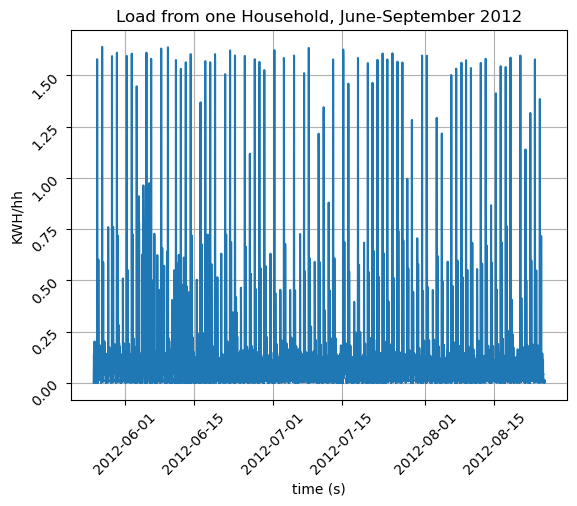

In [38]:
# Visualize load profile for one household meter
fig, ax = plt.subplots()
ax.plot(sample.iloc[100:4500,1], sample.iloc[100:4500,2])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Load from one Household, June-September 2012')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Load from one Household, June-September 2012.png")
plt.show()

In [39]:
# set index for the sample
sample.set_index('tstp')

LCLid  KWHperHH
tstp                                    
2012-05-23 12:00:00  MAC004233     0.009
2012-05-23 12:30:00  MAC004233     0.016
2012-05-23 13:00:00  MAC004233     0.691
2012-05-23 13:30:00  MAC004233     0.154
2012-05-23 14:00:00  MAC004233     0.024
...                        ...       ...
2014-02-27 22:00:00  MAC004233     0.116
2014-02-27 22:30:00  MAC004233     0.123
2014-02-27 23:00:00  MAC004233     0.036
2014-02-27 23:30:00  MAC004233     0.037
2014-02-28 00:00:00  MAC004233     0.020

[30985 rows x 2 columns]

# EDA: Visualize daily average load for each meter and all meters...

52.52859163284302 seconds
58.619816303253174 seconds


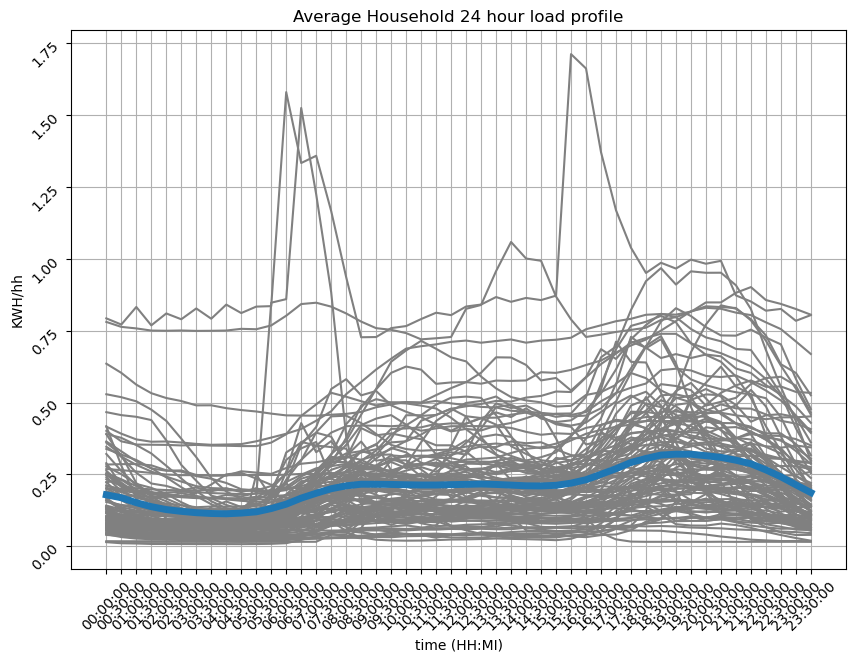

In [40]:
# calculate average daily load profile for all meters...
# abut 1.5 minutes

start_time = time.time()
avgLoadProfile = pd.DataFrame(d.groupby([d['tstp'].dt.hour, d['tstp'].dt.minute]).KWHperHH.mean())
avgLoadProfile = avgLoadProfile.reset_index(names=['hour', 'minute'])
avgLoadProfile['labels'] = pd.to_datetime(avgLoadProfile['hour'].astype(str) + ':' + avgLoadProfile['minute'].astype(str), format='%H:%M').dt.time
print('%s seconds' % (time.time() - start_time))

# print(avgLoadProfile.info())
# print(avgLoadProfile)

fig, ax = plt.subplots(figsize=(10,7))

ax.set_xticks(avgLoadProfile.index, avgLoadProfile.labels)

ax.set(xlabel='time (HH:MI)', ylabel='KWH/hh',
       title='Average Household 24 hour load profile')

# calculate average daily load for each meter...
start_time = time.time()
avgLoadProfileEachMeter = pd.DataFrame(d.groupby(['LCLid', d['tstp'].dt.hour, d['tstp'].dt.minute]).agg({'KWHperHH': 'mean'}))
avgLoadProfileEachMeter = avgLoadProfileEachMeter.reset_index(names=['LCLid', 'hour', 'minute'])
print('%s seconds' % (time.time() - start_time))
# print(avgLoadProfileEachMeter.info())
# print(avgLoadProfileEachMeter)

# plot every sample meter
for meter in sampleMeters:
    # print(meter)
    ax.plot(avgLoadProfileEachMeter.loc[avgLoadProfileEachMeter['LCLid'] == meter].index % 48, 
            avgLoadProfileEachMeter.loc[avgLoadProfileEachMeter['LCLid'] == meter].KWHperHH,
           color='grey')

# plot the average
ax.plot(avgLoadProfile.index, avgLoadProfile.KWHperHH, linewidth=5)

plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Avg 24hr Load Profile every meter.png")
plt.show()

## Create aggregate features: aggregate load (our target) and count of meters

In [41]:
# Calculate the sum of all loads and count of smart meters for each timestamp
start_time = time.time()
aggLoad = pd.DataFrame(d.groupby('tstp')['KWHperHH'].agg({'count', 'sum'}))
aggLoad.reset_index(inplace=True)
aggLoad.columns = ['tstp', 'numMeters', 'AggregateLoad']
print('%s seconds' % (time.time() - start_time))

print(aggLoad)
print(aggLoad.describe())
print(aggLoad.info())

7.210397243499756 seconds
                     tstp  numMeters  AggregateLoad
0     2011-11-23 09:00:00          2       0.569000
1     2011-11-23 09:30:00          2       0.561000
2     2011-11-23 10:00:00          6       0.920000
3     2011-11-23 10:30:00          6       0.588000
4     2011-11-23 11:00:00          7       0.772000
...                   ...        ...            ...
39722 2014-02-27 22:00:00       4987    1494.829500
39723 2014-02-27 22:30:00       4987    1422.109001
39724 2014-02-27 23:00:00       4987    1258.090000
39725 2014-02-27 23:30:00       4987    1073.622001
39726 2014-02-28 00:00:00       4987    1042.266000

[39727 rows x 3 columns]
          numMeters  AggregateLoad
count  39727.000000   39727.000000
mean    4235.611020     896.369164
std     1791.296166     518.309150
min        2.000000       0.561000
25%     4089.000000     533.251967
50%     5137.000000     876.796386
75%     5371.000000    1222.138521
max     5533.000000    2608.409794
<class 'p

In [42]:
aggLoad.sort_values(by=['tstp'], inplace=True)
aggLoad.set_index('tstp', inplace=True)
aggLoad.index.rename('DateTimeIndex', inplace=True)
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   numMeters      39727 non-null  int64  
 1   AggregateLoad  39727 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 931.1 KB


In [43]:
aggLoad['DateTime'] = aggLoad.index
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   numMeters      39727 non-null  int64         
 1   AggregateLoad  39727 non-null  float64       
 2   DateTime       39727 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.2 MB


In [44]:
# inspect and fix records with zero load
# start with the aggregated records with zero load
AggZeros = aggLoad.query("AggregateLoad == 0")
AggZeros

Empty DataFrame
Columns: [numMeters, AggregateLoad, DateTime]
Index: []

Observation: Some of the timestamps are not exactly on the half-hour
Question: How many of the timestamps are not exactly on the half-hour?

In [45]:
# inspect and fix records not exactly on the half-hour
offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)
print(offRecs.info())

# delete records not exactly on the half-hour
aggLoad = aggLoad.drop(offRecs.index)

offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)

Records not exactly on the half-hour:  Empty DataFrame
Columns: [numMeters, AggregateLoad, DateTime]
Index: []
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   numMeters      0 non-null      int64         
 1   AggregateLoad  0 non-null      float64       
 2   DateTime       0 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 0.0 bytes
None
Records not exactly on the half-hour:  Empty DataFrame
Columns: [numMeters, AggregateLoad, DateTime]
Index: []


In [46]:
# check the regularity of the observations (time between observations)
# print(pd.infer_freq(train_data.DateTime))
aggLoad.index.to_series().diff().value_counts()

0 days 00:30:00    39726
Name: DateTimeIndex, dtype: int64

In [47]:
# Calculate moving average and stddev for the aggregated load across all meters
window_size = int(len(aggLoad.AggregateLoad) / 10)
print(window_size)

aggLoadMovingStdev = aggLoad.AggregateLoad.rolling(window_size).std()
aggLoadMovingStdev.columns = ['MovingStdev']

aggLoadMovingAvg = aggLoad.AggregateLoad.rolling(window_size).mean()
aggLoadMovingAvg.columns = ['MovingAvg']

print('aggLoadMovingStdev:\n', aggLoadMovingStdev)
print(aggLoadMovingStdev.info())
print('aggLoadMovingAvg:\n', aggLoadMovingAvg)
print(aggLoadMovingAvg.info())

3972
aggLoadMovingStdev:
 DateTimeIndex
2011-11-23 09:00:00           NaN
2011-11-23 09:30:00           NaN
2011-11-23 10:00:00           NaN
2011-11-23 10:30:00           NaN
2011-11-23 11:00:00           NaN
                          ...    
2014-02-27 22:00:00    399.935227
2014-02-27 22:30:00    399.844494
2014-02-27 23:00:00    399.743831
2014-02-27 23:30:00    399.660375
2014-02-28 00:00:00    399.587636
Name: AggregateLoad, Length: 39727, dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Series name: AggregateLoad
Non-Null Count  Dtype  
--------------  -----  
35756 non-null  float64
dtypes: float64(1)
memory usage: 620.7 KB
None
aggLoadMovingAvg:
 DateTimeIndex
2011-11-23 09:00:00            NaN
2011-11-23 09:30:00            NaN
2011-11-23 10:00:00            NaN
2011-11-23 10:30:00            NaN
2011-11-23 11:00:00            NaN
                          ...     
2014-02-27 22:00:00    1216.267721
20

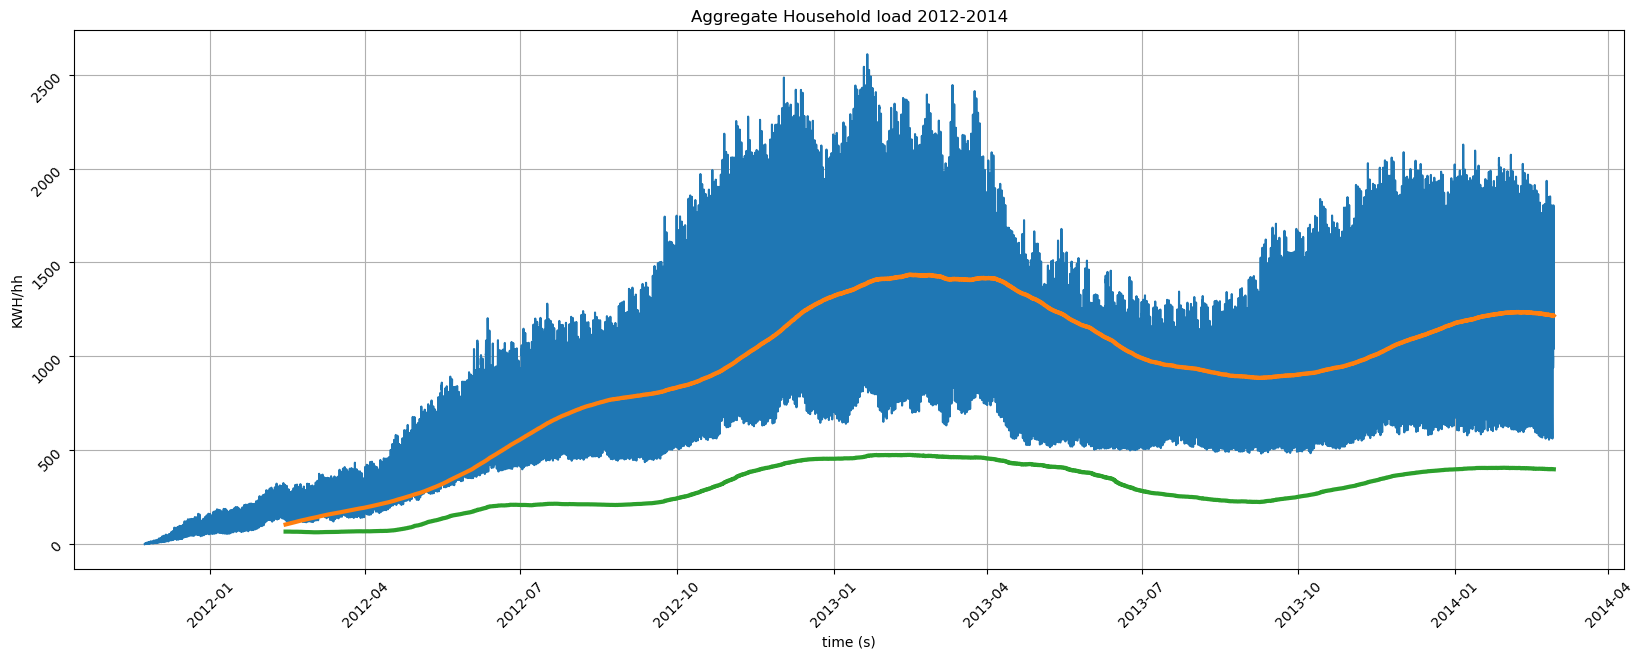

In [48]:
# Visualize aggregate load, moving average, moving standard deviation
# print(aggLoad)
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime, aggLoad.AggregateLoad)
ax.plot(aggLoad.DateTime, aggLoadMovingAvg, linewidth=3)
ax.plot(aggLoad.DateTime, aggLoadMovingStdev, linewidth=3)

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load 2012-2014')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load 2012-2014.png")
plt.show()

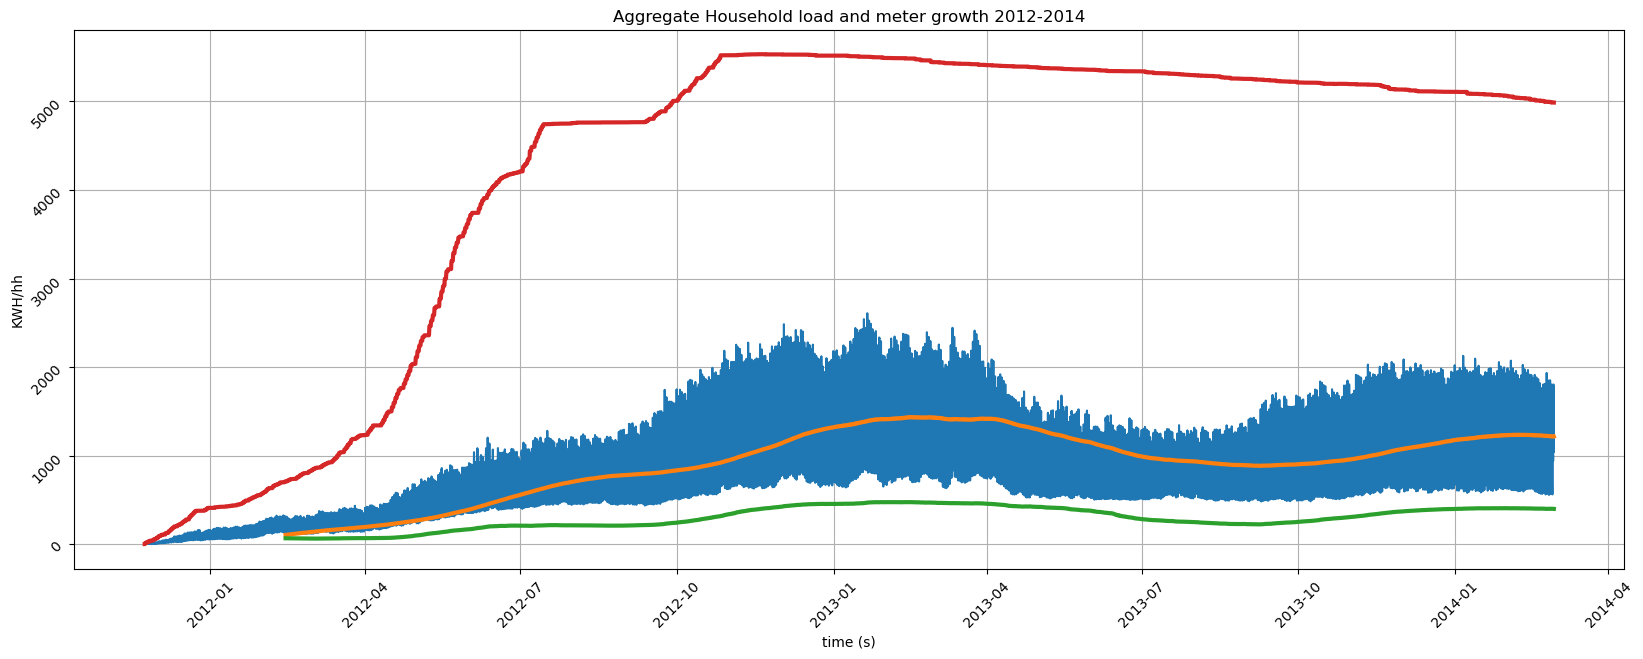

In [49]:
# Add number of meters to aggregate load, moving average, moving standard deviation
# This shows correlation of increased load with meters being added to the program during the recruitment period 
# print(aggLoad)
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime, aggLoad.AggregateLoad)
ax.plot(aggLoad.DateTime, aggLoadMovingAvg, linewidth=3)
ax.plot(aggLoad.DateTime, aggLoadMovingStdev, linewidth=3)
ax.plot(aggLoad.DateTime, aggLoad.numMeters, linewidth=3)

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load and meter growth 2012-2014')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load and meter growth 2012-2014.png")
plt.show()

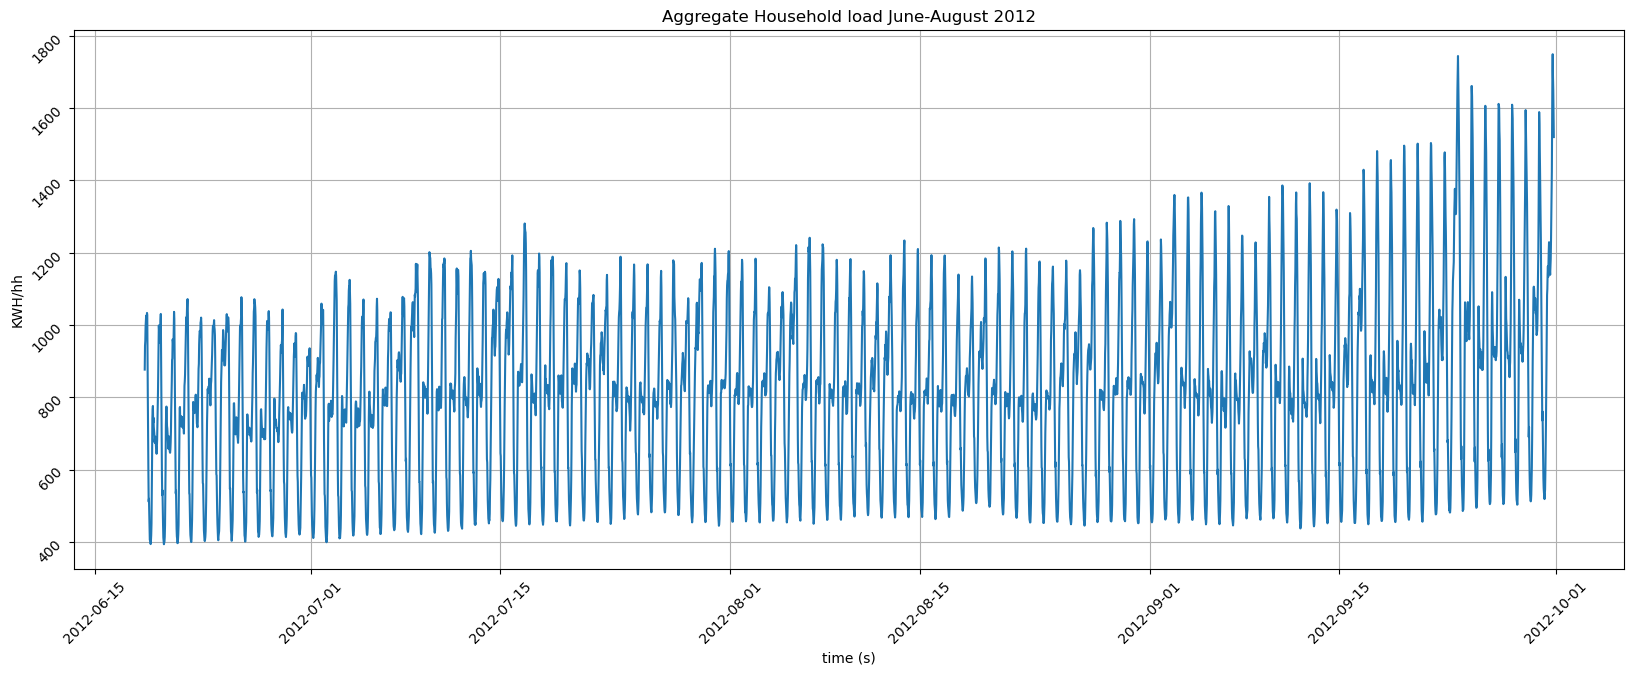

In [50]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[10000:15000], aggLoad.AggregateLoad[10000:15000])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load June-August 2012')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load June-August 2012.png")
plt.show()

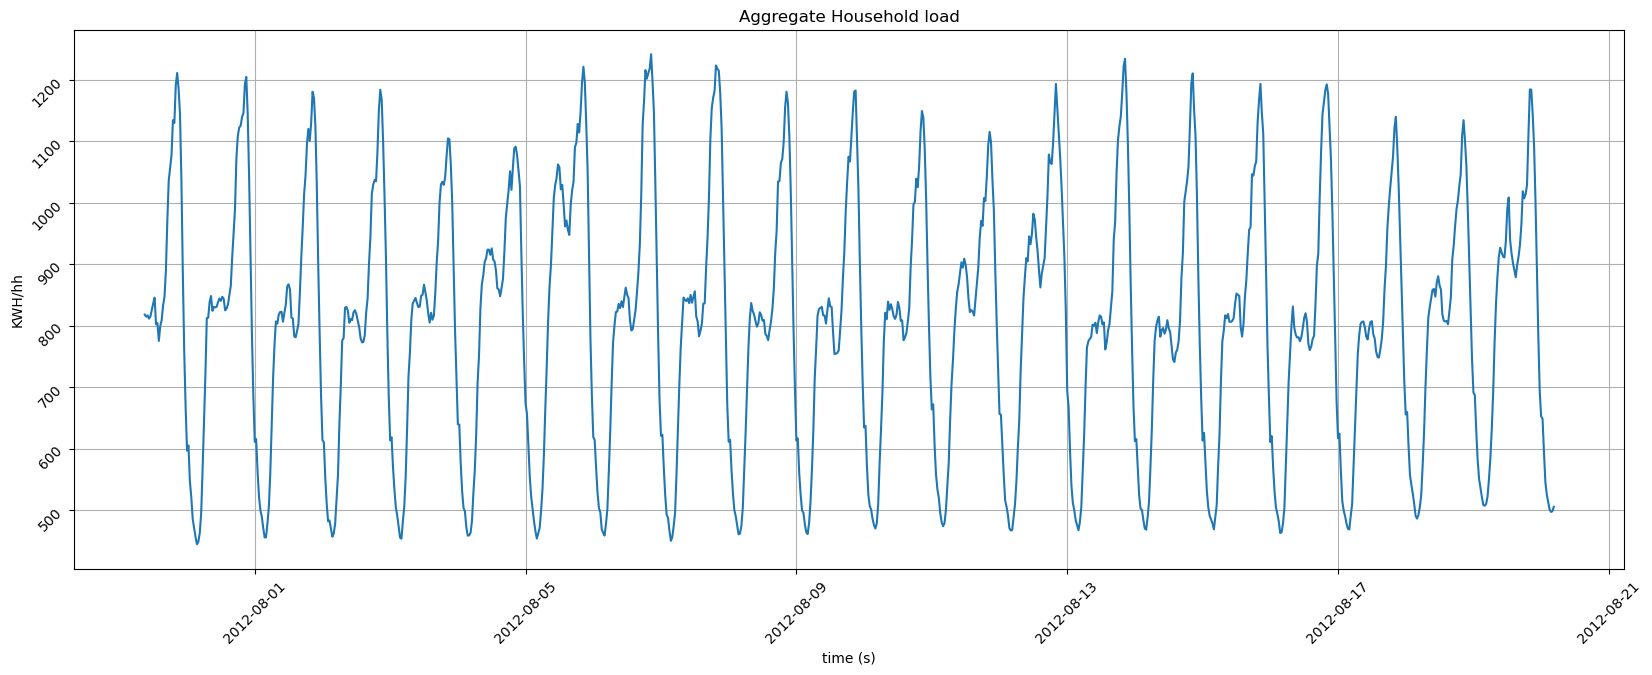

In [51]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[12000:13000], aggLoad.AggregateLoad[12000:13000])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load one month.png")
plt.show()

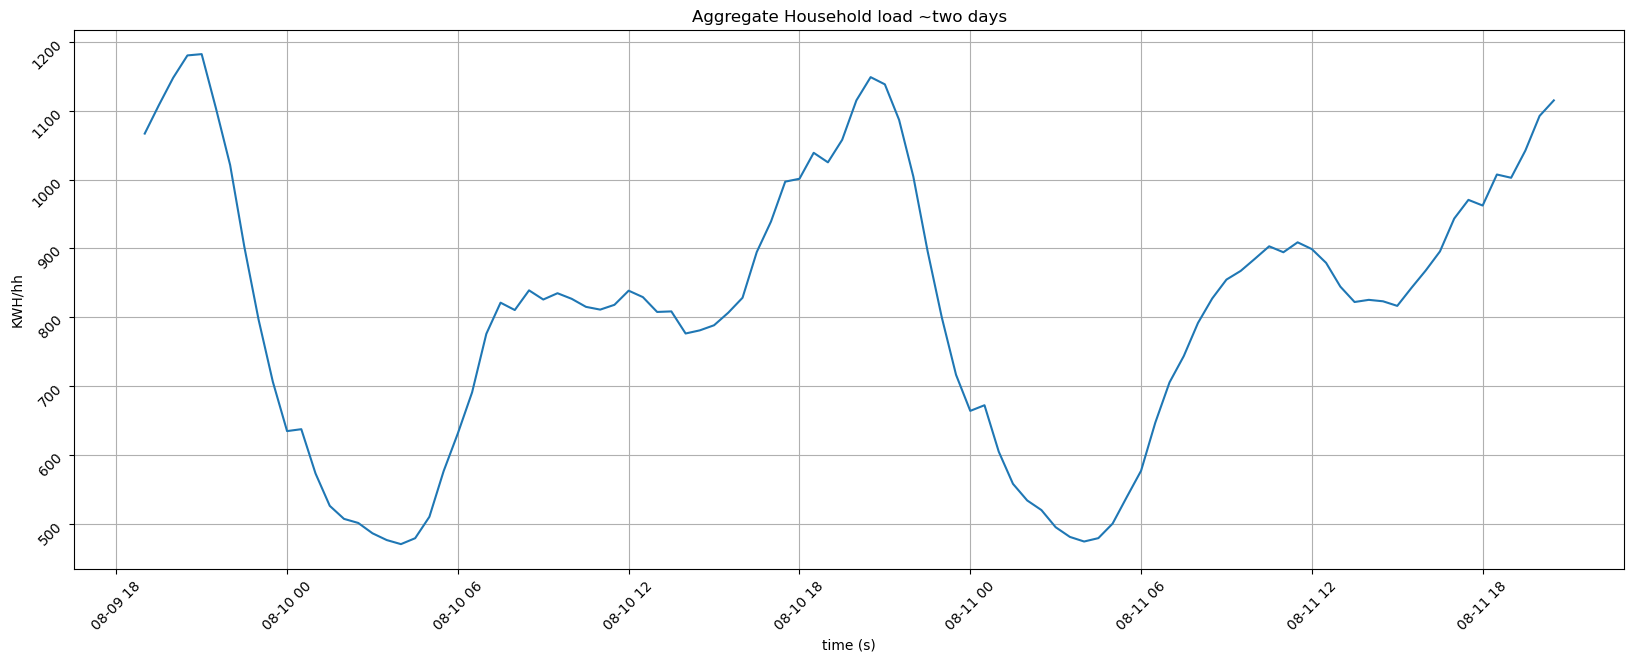

In [52]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[12500:12600], aggLoad.AggregateLoad[12500:12600])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load ~two days')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load two days.png")
plt.show()

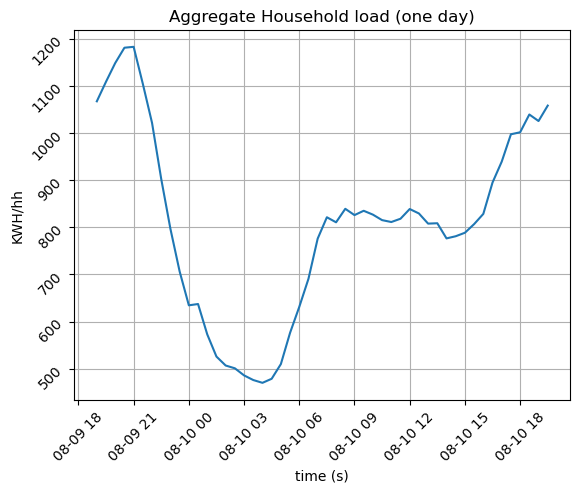

In [53]:
fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime[12500:12550], aggLoad.AggregateLoad[12500:12550])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load (one day)')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load (one day).png")
plt.show()

In [54]:
aggLoad.to_csv('/kaggle/working/aggLoadDataFinal.csv',index=False)

In [55]:
aggLoad = pd.read_csv('/kaggle/working/aggLoadDataFinal.csv', parse_dates=["DateTime"])
aggLoad

numMeters  AggregateLoad            DateTime
0              2       0.569000 2011-11-23 09:00:00
1              2       0.561000 2011-11-23 09:30:00
2              6       0.920000 2011-11-23 10:00:00
3              6       0.588000 2011-11-23 10:30:00
4              7       0.772000 2011-11-23 11:00:00
...          ...            ...                 ...
39722       4987    1494.829500 2014-02-27 22:00:00
39723       4987    1422.109001 2014-02-27 22:30:00
39724       4987    1258.090000 2014-02-27 23:00:00
39725       4987    1073.622001 2014-02-27 23:30:00
39726       4987    1042.266000 2014-02-28 00:00:00

[39727 rows x 3 columns]

In [56]:
# Add features useful for time series
!pip install scikit-learn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

## Feature engineering

### Cyclical features

In [57]:
# Add features useful for time series
print(aggLoad.info())
# Cyclical features
# week of year
weekOfYear = aggLoad.DateTime.dt.weekofyear
aggLoad["weekOfYear_sin"] = np.sin(weekOfYear*(2.*np.pi/52))
aggLoad["weekOfYear_cos"] = np.cos(weekOfYear*(2.*np.pi/52))
# day of week
dayOfWeek = aggLoad.DateTime.dt.dayofweek
aggLoad["dayOfWeek_sin"] = np.sin(dayOfWeek*(2.*np.pi/7))
aggLoad["dayOfWeek_cos"] = np.cos(dayOfWeek*(2.*np.pi/7))
# day of year
# aggLoad["dayOfYear"] = aggLoad.DateTime.dt.dayofyear
# minute of the day
minuteOfDay = (aggLoad.DateTime.dt.hour * 60) + aggLoad.DateTime.dt.minute
aggLoad["minuteOfDay_sin"] = np.sin(minuteOfDay*(2.*np.pi/48))
aggLoad["minuteOfDay_cos"] = np.cos(minuteOfDay*(2.*np.pi/48))

cyclicalFeatureNames = ['dayOfWeek_sin', 'dayOfWeek_cos', 'minuteOfDay_sin', 'minuteOfDay_cos', 'weekOfYear_sin', 'weekOfYear_cos']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39727 entries, 0 to 39726
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   numMeters      39727 non-null  int64         
 1   AggregateLoad  39727 non-null  float64       
 2   DateTime       39727 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 931.2 KB
None


## Decomposition features

In [58]:
decomp_df = pd.DataFrame(aggLoad.copy())
decomp_df = decomp_df.set_index(pd.DatetimeIndex(decomp_df['DateTime']))
decomp_df.index=decomp_df.DateTime
decomp_df = decomp_df.AggregateLoad
print(decomp_df.describe())
print(decomp_df.info)

count    39727.000000
mean       896.369164
std        518.309150
min          0.561000
25%        533.251967
50%        876.796386
75%       1222.138521
max       2608.409794
Name: AggregateLoad, dtype: float64
<bound method Series.info of DateTime
2011-11-23 09:00:00       0.569000
2011-11-23 09:30:00       0.561000
2011-11-23 10:00:00       0.920000
2011-11-23 10:30:00       0.588000
2011-11-23 11:00:00       0.772000
                          ...     
2014-02-27 22:00:00    1494.829500
2014-02-27 22:30:00    1422.109001
2014-02-27 23:00:00    1258.090000
2014-02-27 23:30:00    1073.622001
2014-02-28 00:00:00    1042.266000
Name: AggregateLoad, Length: 39727, dtype: float64>


In [59]:
'''
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decomp = seasonal_decompose(decomp_df)
seasonal_decomp.plot()
'''

'\nfrom statsmodels.tsa.seasonal import seasonal_decompose\nseasonal_decomp = seasonal_decompose(decomp_df)\nseasonal_decomp.plot()\n'

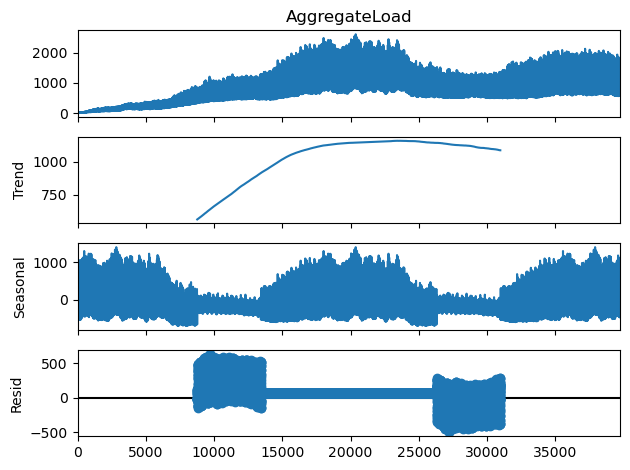

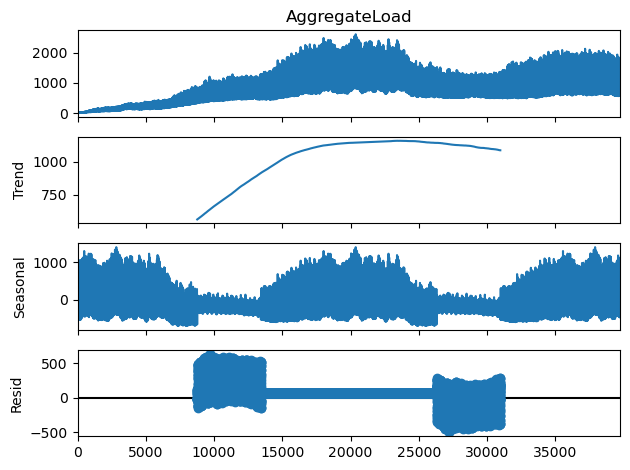

In [60]:
# Annual decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
yearly_seasonal_decomp = seasonal_decompose(aggLoad['AggregateLoad'], period=17532)
aggLoad['yearlySeasonal']=yearly_seasonal_decomp.seasonal
yearly_seasonal_decomp.plot()

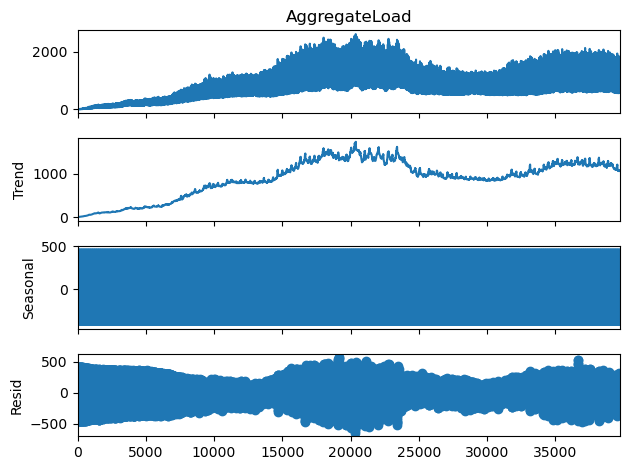

In [61]:
# daily decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
daily_seasonal_decomp = seasonal_decompose(aggLoad['AggregateLoad'], period=48)
aggLoad['dailyTrend']=daily_seasonal_decomp.trend
aggLoad['dailySeasonal']=daily_seasonal_decomp.seasonal
aggLoad['dailyResid']=daily_seasonal_decomp.resid
daily_seasonal_decomp.plot();

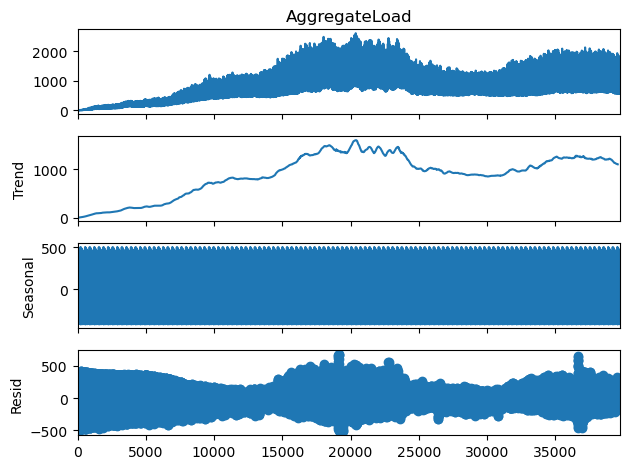

In [62]:
# weekly decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
weekly_seasonal_decomp = seasonal_decompose(aggLoad['AggregateLoad'], period=336)
aggLoad['weeklyTrend']=weekly_seasonal_decomp.trend
aggLoad['weeklySeasonal']=weekly_seasonal_decomp.seasonal
aggLoad['weeklyResid']=weekly_seasonal_decomp.resid
weekly_seasonal_decomp.plot();

### Lag features

In [63]:
# load 1 day lag
oneDayPeriods = 48
aggLoad['AggregateLoad_1dayLag'] = aggLoad['AggregateLoad'].shift(oneDayPeriods)
# load 1 week lag
oneWeekPeriods = oneDayPeriods * 7
aggLoad['AggregateLoad_1weekLag'] = aggLoad['AggregateLoad'].shift(oneWeekPeriods)

# load change from last half-hour to this half-hour
aggLoad['AggregateLoad_halfhourdiff'] = aggLoad['AggregateLoad'] - aggLoad['AggregateLoad'].shift(1)
# load change from one week ago to this half-hour
aggLoad['AggregateLoad_weekdiff'] = aggLoad['AggregateLoad'] - aggLoad['AggregateLoad'].shift(oneWeekPeriods)

print(aggLoad.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39727 entries, 0 to 39726
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   numMeters                   39727 non-null  int64         
 1   AggregateLoad               39727 non-null  float64       
 2   DateTime                    39727 non-null  datetime64[ns]
 3   weekOfYear_sin              39727 non-null  float64       
 4   weekOfYear_cos              39727 non-null  float64       
 5   dayOfWeek_sin               39727 non-null  float64       
 6   dayOfWeek_cos               39727 non-null  float64       
 7   minuteOfDay_sin             39727 non-null  float64       
 8   minuteOfDay_cos             39727 non-null  float64       
 9   yearlySeasonal              39727 non-null  float64       
 10  dailyTrend                  39679 non-null  float64       
 11  dailySeasonal               39727 non-null  float64   

In [64]:
# drop NaNs created by feature engineering
aggLoad.dropna(inplace=True)

In [65]:
# temperature change from last half-hour to this half-hour
# eliminated due to permutation feature importance
# weatherUpsample['temp_halfhourdiff'] = weatherUpsample['temperature'] - weatherUpsample['temperature'].shift(1)

# max temp for the day
weatherUpsample['temp_daymax'] = weatherUpsample.groupby(weatherUpsample.DateTime.dt.date)['temperature'].transform('max')
weatherUpsample['temp_daymin'] = weatherUpsample.groupby(weatherUpsample.DateTime.dt.date)['temperature'].transform('min')
print(weatherUpsample['temp_daymax'])
print(weatherUpsample['temp_daymin'])

0        15.57
1        15.57
2        15.57
3        15.57
4        15.57
         ...  
42328    16.37
42329    16.37
42330    16.37
42331    16.37
42332    16.37
Name: temp_daymax, Length: 42333, dtype: float64
0         9.68
1         9.68
2         9.68
3         9.68
4         9.68
         ...  
42328    10.98
42329    10.98
42330    10.98
42331    10.98
42332    10.98
Name: temp_daymin, Length: 42333, dtype: float64


In [66]:
"""
# Find the earliest date when there is the maximum number of meters contributing to the aggregate load
# will disreard all data beofre this point
maxMeters = aggLoad['numMeters'].max()
print(maxMeters)
startDateTime = aggLoad[aggLoad['numMeters']==maxMeters].DateTime.min()
print(startDateTime)
startDate = startDateTime.date()
print(startDate)
"""

"\n# Find the earliest date when there is the maximum number of meters contributing to the aggregate load\n# will disreard all data beofre this point\nmaxMeters = aggLoad['numMeters'].max()\nprint(maxMeters)\nstartDateTime = aggLoad[aggLoad['numMeters']==maxMeters].DateTime.min()\nprint(startDateTime)\nstartDate = startDateTime.date()\nprint(startDate)\n"

In [67]:
"""
# delete records during the ramp up phase when meters are being gradually added to the dataset
indexDate = aggLoad[ aggLoad['DateTime'].dt.date < startDate].index
aggLoad.drop(indexDate , inplace=True)
aggLoad
"""

"\n# delete records during the ramp up phase when meters are being gradually added to the dataset\nindexDate = aggLoad[ aggLoad['DateTime'].dt.date < startDate].index\naggLoad.drop(indexDate , inplace=True)\naggLoad\n"

In [68]:
# Join load data and weather data
mergeData = pd.merge(aggLoad, weatherUpsample, on='DateTime', copy=False)
print(mergeData.info())
mergeData

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39223 entries, 0 to 39222
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   numMeters                   39223 non-null  int64         
 1   AggregateLoad               39223 non-null  float64       
 2   DateTime                    39223 non-null  datetime64[ns]
 3   weekOfYear_sin              39223 non-null  float64       
 4   weekOfYear_cos              39223 non-null  float64       
 5   dayOfWeek_sin               39223 non-null  float64       
 6   dayOfWeek_cos               39223 non-null  float64       
 7   minuteOfDay_sin             39223 non-null  float64       
 8   minuteOfDay_cos             39223 non-null  float64       
 9   yearlySeasonal              39223 non-null  float64       
 10  dailyTrend                  39223 non-null  float64       
 11  dailySeasonal               39223 non-null  float64   

numMeters  AggregateLoad            DateTime  weekOfYear_sin  \
0             64      10.951000 2011-11-30 09:00:00       -0.464723   
1             66      12.916000 2011-11-30 09:30:00       -0.464723   
2             69      12.444000 2011-11-30 10:00:00       -0.464723   
3             70      12.323000 2011-11-30 10:30:00       -0.464723   
4             70      10.693500 2011-11-30 11:00:00       -0.464723   
...          ...            ...                 ...             ...   
39218       4996    1039.866996 2014-02-24 10:00:00        0.885456   
39219       4996    1023.987486 2014-02-24 10:30:00        0.885456   
39220       4996     996.960474 2014-02-24 11:00:00        0.885456   
39221       4996     977.749466 2014-02-24 11:30:00        0.885456   
39222       4996     981.974620 2014-02-24 12:00:00        0.885456   

       weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos  minuteOfDay_sin  \
0            0.885456       0.974928      -0.222521     1.000000e+00   
1            0.885456       0.974928      -0.222521    -7.071068e-01   
2            0.885456       0.974928      -0.222521     1.371976e-14   
3            0.885456       0.974928      -0.222521     7.071068e-01   
4            0.885456       0.974928      -0.222521    -1.000000e+00   
...               ...            ...            ...              ...   
39218        0.464723       0.000000       1.000000     1.371976e-14   
39219        0.464723       0.000000       1.000000     7.071068e-01   
39220        0.464723       0.000000       1.000000    -1.000000e+00   
39221        0.464723       0.000000       1.000000     7.071068e-01   
39222        0.464723       0.000000       1.000000    -1.077937e-14   

       minuteOfDay_cos  yearlySeasonal  ...  weeklySeasonal  weeklyResid  \
0         9.790985e-16       43.209702  ...       -3.517150    -0.876478   
1         7.071068e-01       90.896703  ...      -18.413807    15.918301   
2        -1.000000e+00      227.575081  ...      -32.990513    29.963428   
3         7.071068e-01      477.915041  ...      -42.123696    38.922464   
4        -1.224956e-14      708.690667  ...      -45.024905    40.149581   
...                ...             ...  ...             ...          ...   
39218    -1.000000e+00     -404.721545  ...       -9.128025   -53.183671   
39219     7.071068e-01     -411.773097  ...      -16.579063   -61.693846   
39220    -1.224956e-14     -412.170203  ...      -22.963748   -82.407635   
39221    -7.071068e-01     -388.306826  ...      -17.737587  -106.821457   
39222     1.000000e+00     -368.614274  ...      -13.505024  -106.718797   

       AggregateLoad_1dayLag  AggregateLoad_1weekLag  \
0                   9.500000                0.569000   
1                   8.304000                0.561000   
2                   9.475000                0.920000   
3                  10.045000                0.588000   
4                   9.096000                0.772000   
...                      ...                     ...   
39218            1262.133219             1166.933389   
39219            1284.125044             1145.325656   
39220            1290.955870             1144.804591   
39221            1343.646697             1141.465524   
39222            1364.942521             1127.796459   

       AggregateLoad_halfhourdiff  AggregateLoad_weekdiff  temperature  \
0                        0.134000               10.382000        7.660   
1                        1.965000               12.355000        8.695   
2                       -0.472000               11.524000        9.730   
3                       -0.121000               11.735000       10.510   
4                       -1.629500                9.921500       11.290   
...                           ...                     ...          ...   
39218                  -26.388344             -127.066393       11.320   
39219                  -15.879510             -121.338171       11.890   
39220                  -27.027011    

In [69]:
# Move first column to the Last
# df = pd.DataFrame(mergeData)
df = mergeData
temp_cols=df.columns.tolist()
new_cols=temp_cols[1:] + temp_cols[0:1]
mergeData=df[new_cols]
print(mergeData)

       AggregateLoad            DateTime  weekOfYear_sin  weekOfYear_cos  \
0          10.951000 2011-11-30 09:00:00       -0.464723        0.885456   
1          12.916000 2011-11-30 09:30:00       -0.464723        0.885456   
2          12.444000 2011-11-30 10:00:00       -0.464723        0.885456   
3          12.323000 2011-11-30 10:30:00       -0.464723        0.885456   
4          10.693500 2011-11-30 11:00:00       -0.464723        0.885456   
...              ...                 ...             ...             ...   
39218    1039.866996 2014-02-24 10:00:00        0.885456        0.464723   
39219    1023.987486 2014-02-24 10:30:00        0.885456        0.464723   
39220     996.960474 2014-02-24 11:00:00        0.885456        0.464723   
39221     977.749466 2014-02-24 11:30:00        0.885456        0.464723   
39222     981.974620 2014-02-24 12:00:00        0.885456        0.464723   

       dayOfWeek_sin  dayOfWeek_cos  minuteOfDay_sin  minuteOfDay_cos  \
0           0.

In [70]:
from pandas_profiling import ProfileReport

profile = ProfileReport(mergeData, tsmode=True, sortby="DateTime")
profile.to_file('mergeData profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [71]:
# Remove the dateTime feature from the dataset (we've extracted to features we need from it)
print(mergeData)
mergeData.drop(columns=['DateTime'], inplace=True)

       AggregateLoad            DateTime  weekOfYear_sin  weekOfYear_cos  \
0          10.951000 2011-11-30 09:00:00       -0.464723        0.885456   
1          12.916000 2011-11-30 09:30:00       -0.464723        0.885456   
2          12.444000 2011-11-30 10:00:00       -0.464723        0.885456   
3          12.323000 2011-11-30 10:30:00       -0.464723        0.885456   
4          10.693500 2011-11-30 11:00:00       -0.464723        0.885456   
...              ...                 ...             ...             ...   
39218    1039.866996 2014-02-24 10:00:00        0.885456        0.464723   
39219    1023.987486 2014-02-24 10:30:00        0.885456        0.464723   
39220     996.960474 2014-02-24 11:00:00        0.885456        0.464723   
39221     977.749466 2014-02-24 11:30:00        0.885456        0.464723   
39222     981.974620 2014-02-24 12:00:00        0.885456        0.464723   

       dayOfWeek_sin  dayOfWeek_cos  minuteOfDay_sin  minuteOfDay_cos  \
0           0.

In [72]:
# get list of continuos features for standardization
continuousColumnNames = [e for e in mergeData.columns if e not in (cyclicalFeatureNames)]
continuousColumnNames

['AggregateLoad',
 'yearlySeasonal',
 'dailyTrend',
 'dailySeasonal',
 'dailyResid',
 'weeklyTrend',
 'weeklySeasonal',
 'weeklyResid',
 'AggregateLoad_1dayLag',
 'AggregateLoad_1weekLag',
 'AggregateLoad_halfhourdiff',
 'AggregateLoad_weekdiff',
 'temperature',
 'dewPoint',
 'temp_daymax',
 'temp_daymin',
 'numMeters']

## Plot autocorrelation of aggregate load (target) to investigate cyclical properties

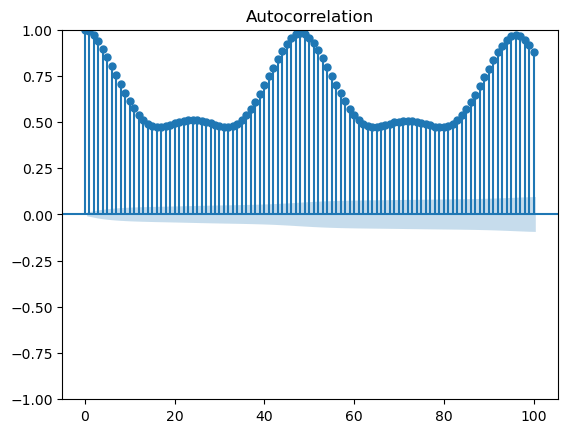

In [73]:
from statsmodels.graphics.tsaplots import plot_acf

# Extract the AggregateLoad feature
aggregate_load = mergeData['AggregateLoad']

# Plot the autocorrelation plot
plot_acf(aggregate_load, lags=100)

# Show the plot
plt.show()

## Final feature selection

In [74]:
# select features
# mergeData = mergeData[['AggregateLoad_1dayLag', 'AggregateLoad_1weekLag', 'dayOfWeek', 'temperature','AggregateLoad']]
# mergeData = mergeData[['numMeters', 'temperature', 'minuteOfDay_sin', 'minuteOfDay_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'weekOfYear_sin', 'weekOfYear_cos', 'AggregateLoad']]
# mergeData = mergeData[['numMeters', 'minuteOfDay_sin', 'minuteOfDay_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'weekOfYear_sin', 'weekOfYear_cos', 'AggregateLoad']]
# mergeData = mergeData[['minuteOfDay_sin', 'minuteOfDay_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'weekOfYear_sin', 'weekOfYear_cos', 'AggregateLoad']]
# mergeData = mergeData[['AggregateLoad']]
# remove features dues to feature permutation importance
mergeData.drop(columns=['numMeters', 'yearlySeasonal'], inplace=True)
mergeData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39223 entries, 0 to 39222
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AggregateLoad               39223 non-null  float64
 1   weekOfYear_sin              39223 non-null  float64
 2   weekOfYear_cos              39223 non-null  float64
 3   dayOfWeek_sin               39223 non-null  float64
 4   dayOfWeek_cos               39223 non-null  float64
 5   minuteOfDay_sin             39223 non-null  float64
 6   minuteOfDay_cos             39223 non-null  float64
 7   dailyTrend                  39223 non-null  float64
 8   dailySeasonal               39223 non-null  float64
 9   dailyResid                  39223 non-null  float64
 10  weeklyTrend                 39223 non-null  float64
 11  weeklySeasonal              39223 non-null  float64
 12  weeklyResid                 39223 non-null  float64
 13  AggregateLoad_1dayLag       392

In [75]:
mergeData.drop(columns=['dewPoint', 'minuteOfDay_sin', 'minuteOfDay_cos', 'temp_daymin', 'AggregateLoad_weekdiff'], inplace=True)
mergeData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39223 entries, 0 to 39222
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AggregateLoad               39223 non-null  float64
 1   weekOfYear_sin              39223 non-null  float64
 2   weekOfYear_cos              39223 non-null  float64
 3   dayOfWeek_sin               39223 non-null  float64
 4   dayOfWeek_cos               39223 non-null  float64
 5   dailyTrend                  39223 non-null  float64
 6   dailySeasonal               39223 non-null  float64
 7   dailyResid                  39223 non-null  float64
 8   weeklyTrend                 39223 non-null  float64
 9   weeklySeasonal              39223 non-null  float64
 10  weeklyResid                 39223 non-null  float64
 11  AggregateLoad_1dayLag       39223 non-null  float64
 12  AggregateLoad_1weekLag      39223 non-null  float64
 13  AggregateLoad_halfhourdiff  392

In [76]:
mergeData.to_csv('/kaggle/working/mergeDataFinal.csv',index=False)

In [77]:
mergeData = pd.read_csv('/kaggle/working/mergeDataFinal.csv')
mergeData

AggregateLoad  weekOfYear_sin  weekOfYear_cos  dayOfWeek_sin  \
0          10.951000       -0.464723        0.885456       0.974928   
1          12.916000       -0.464723        0.885456       0.974928   
2          12.444000       -0.464723        0.885456       0.974928   
3          12.323000       -0.464723        0.885456       0.974928   
4          10.693500       -0.464723        0.885456       0.974928   
...              ...             ...             ...            ...   
39218    1039.866996        0.885456        0.464723       0.000000   
39219    1023.987486        0.885456        0.464723       0.000000   
39220     996.960474        0.885456        0.464723       0.000000   
39221     977.749466        0.885456        0.464723       0.000000   
39222     981.974620        0.885456        0.464723       0.000000   

       dayOfWeek_cos   dailyTrend  dailySeasonal  dailyResid  weeklyTrend  \
0          -0.222521    13.699760      17.604790  -20.353550    15.344628   
1          -0.222521    13.788406      15.719849  -16.592255    15.411506   
2          -0.222521    13.842333      11.024520  -12.422854    15.471085   
3          -0.222521    13.869135       7.349837   -8.895972    15.524232   
4          -0.222521    13.923563       7.485270  -10.715332    15.568824   
...              ...          ...            ...         ...          ...   
39218       1.000000  1086.726060      11.024520  -57.883584  1102.178691   
39219       1.000000  1085.785208       7.349837  -69.147559  1102.260395   
39220       1.000000  1085.043054       7.485270  -95.567849  1102.331858   
39221       1.000000  1084.517179      12.996418 -119.764132  1102.308509   
39222       1.000000  1083.905137      17.191010 -119.121527  1102.198442   

       weeklySeasonal  weeklyResid  AggregateLoad_1dayLag  \
0           -3.517150    -0.876478               9.500000   
1          -18.413807    15.918301               8.304000   
2          -32.990513    29.963428               9.475000   
3          -42.123696    38.922464              10.045000   
4          -45.024905    40.149581               9.096000   
...               ...          ...                    ...   
39218       -9.128025   -53.183671            1262.133219   
39219      -16.579063   -61.693846            1284.125044   
39220      -22.963748   -82.407635            1290.955870   
39221      -17.737587  -106.821457            1343.646697   
39222      -13.505024  -106.718797            1364.942521   

       AggregateLoad_1weekLag  AggregateLoad_halfhourdiff  temperature  \
0                    0.569000                    0.134000        7.660   
1                    0.561000                    1.965000        8.695   
2                    0.920000                   -0.472000        9.730   
3                    0.588000                   -0.121000       10.510   
4                    0.772000                   -1.629500       11.290   
...                       ...                         ...          ...   
39218             1166.933389                  -26.388344       11.320   
39219             1145.325656                  -15.879510       11.890   
39220             1144.804591                  -27.027011       12.460   
39221             1141.465524                  -19.211009       12.765   
39222             1127.796459                    4.225155       13.070   

       temp_daymax  
0            11.87  
1            11.87  
2            11.87  
3            11.87  
4            11.87  
...            ...  
39218        14.23  
39219        14.23  
39220        14.23  
39221        14.23  
39222        14.23  

[39223 rows x 16 columns]

In [78]:
# profile = ProfileReport(mergeDataFinal, tsmode=True, sortby="time")
# profile.to_file('mergeDataFinal profile_report.html')

## Training, Validation, Testing Split

In [79]:
# Split the time series data into train, test, and validation datasets
train_size = int(len(mergeData) * 0.7)  # 70% for training
val_size = int(len(mergeData) * 0.2)   # 20% for validation
test_size = len(mergeData) - val_size - train_size  # Remaining 10% for testing

train_data = mergeData[:train_size].copy()
train_data.reset_index(drop=True, inplace=True)
val_data = mergeData[train_size:train_size+val_size].copy()
val_data.reset_index(drop=True, inplace=True)
test_data = mergeData[train_size+val_size:].copy()
test_data.reset_index(drop=True, inplace=True)

print('\ntrain_data.head()\n', train_data.head())
print(train_data.info())
print('\nval_data.head()\n', val_data.head())
print(val_data.info())
print('\ntest_data.head()\n', test_data.head())
print(test_data.info())

num_out_features = mergeData.shape[1]
label_columns = ['AggregateLoad']


train_data.head()
    AggregateLoad  weekOfYear_sin  weekOfYear_cos  dayOfWeek_sin  \
0        10.9510       -0.464723        0.885456       0.974928   
1        12.9160       -0.464723        0.885456       0.974928   
2        12.4440       -0.464723        0.885456       0.974928   
3        12.3230       -0.464723        0.885456       0.974928   
4        10.6935       -0.464723        0.885456       0.974928   

   dayOfWeek_cos  dailyTrend  dailySeasonal  dailyResid  weeklyTrend  \
0      -0.222521   13.699760      17.604790  -20.353550    15.344628   
1      -0.222521   13.788406      15.719849  -16.592255    15.411506   
2      -0.222521   13.842333      11.024520  -12.422854    15.471085   
3      -0.222521   13.869135       7.349837   -8.895972    15.524232   
4      -0.222521   13.923563       7.485270  -10.715332    15.568824   

   weeklySeasonal  weeklyResid  AggregateLoad_1dayLag  AggregateLoad_1weekLag  \
0       -3.517150    -0.876478                  9.500          

In [80]:
def prediction_plot(testY, test_predict):
      len_prediction=[x for x in range(len(testY))]
      plt.figure(figsize=(20,5))
      plt.plot(len_prediction, testY, marker='.', label="actual")
      plt.plot(len_prediction, test_predict, 'r', label="prediction")
      plt.tight_layout()
      sns.despine(top=True)
      plt.subplots_adjust(left=0.07)
      plt.ylabel('KWH per half hour', size=15)
      plt.xlabel('Time step', size=15)
      plt.legend(fontsize=15)
      plt.show();

## Standardize the data

In [81]:
# Standardize the data
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

mergeDataNormed = (mergeData - train_mean) / train_std

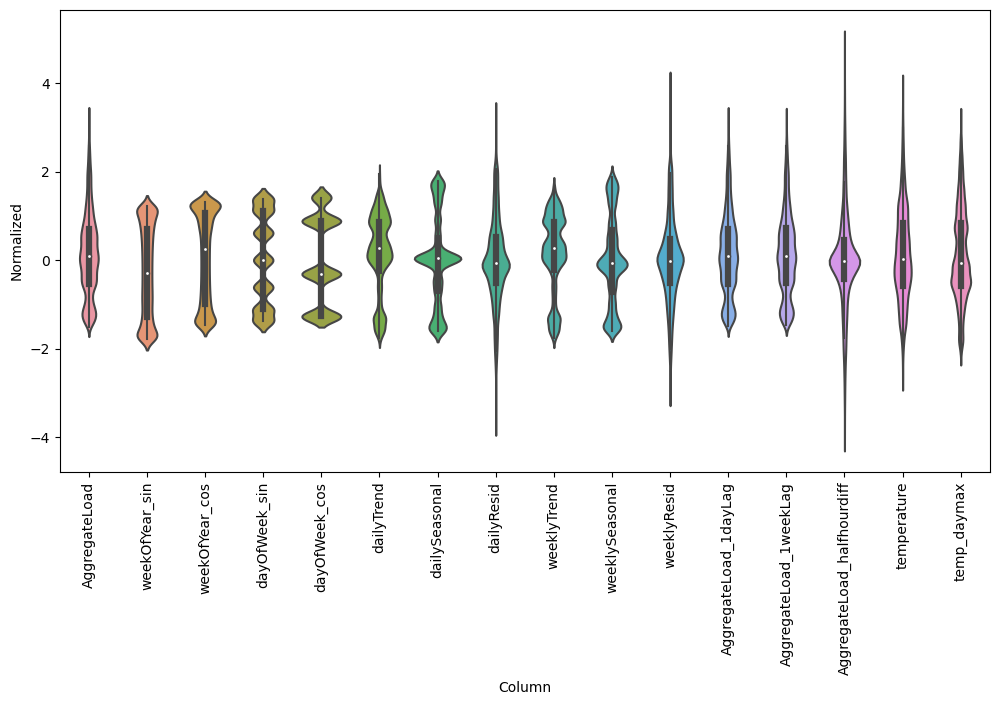

In [82]:
# Visualize distribution of the features
# df_std = (mergeData - train_mean) / train_std
df_std = mergeDataNormed.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(mergeData.keys(), rotation=90)
plt.savefig('violin_plot.png', format='png')


In [83]:
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score

# Split the data into features and target
X = mergeDataNormed.drop(columns=['AggregateLoad'])
y = mergeDataNormed['AggregateLoad']

# Calculate mutual information between each feature and the target variable
mutual_information_scores = []
for feature in X.columns:
    mutual_information_score = mutual_info_score(X[feature], y)
    mutual_information_scores.append([feature,mutual_information_score])
    
MISdf = pd.DataFrame(mutual_information_scores, columns=['Feature', 'Mutual information score'])
# Print the mutual information scores
# print('Mutual information scores:', mutual_information_scores)
print(MISdf.sort_values('Mutual information score', ascending=False))


                       Feature  Mutual information score
4                   dailyTrend                 10.576700
6                   dailyResid                 10.576700
7                  weeklyTrend                 10.576700
9                  weeklyResid                 10.576700
12  AggregateLoad_halfhourdiff                 10.576559
10       AggregateLoad_1dayLag                 10.576382
11      AggregateLoad_1weekLag                 10.576312
13                 temperature                  8.322565
14                 temp_daymax                  6.456673
8               weeklySeasonal                  5.816786
5                dailySeasonal                  3.870883
0               weekOfYear_sin                  3.767587
1               weekOfYear_cos                  3.739196
2                dayOfWeek_sin                  1.945623
3                dayOfWeek_cos                  1.945623


In [84]:
from pandas_profiling import ProfileReport

# profile = ProfileReport(mergeDataNormed, tsmode=True, sortby=int(mergeDataNormed.index))
# profile.to_file('mergeDataNormed profile_report.html')
# profile

## Functions for preparing data for time series machine learning

Not my work

Credit to [Tensorflow Tutorial: Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [85]:
class WindowGenerator():
    # https://www.tensorflow.org/tutorials/structured_data/time_series#1_indexes_and_offsets
  def __init__(self, input_width, label_width, shift,
               train_df=train_data, val_df=val_data, test_df=test_data,
               label_columns=None):
    # print('\nWindowGenerator.__init__\n')
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    # print('\nlabel_columns:\n', label_columns)
    # Work out the label column indices.
    self.label_columns = label_columns
    self.num_out_features = train_df.shape[1] # default to predicting all input columns
    
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
      self.num_out_features = len(label_columns) # JS added this
      # print('\nself.num_out_features:', self.num_out_features)
      
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [86]:
def split_window(self, features):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#2_split
  # print('\nsplit_window\n', features)
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [87]:
def plot(self, model=None, plot_col='AggregateLoad', max_subplots=3):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#3_plot
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [88]:
def make_dataset(self, data):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#4_create_tfdatadatasets
  # print('\nmake_dataset\n', data)
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      seed=randomState,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [89]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#4_create_tfdatadatasets
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Create data windows for time series forecasting


num_out_features:  1


Total window size: 96
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label column name(s): ['AggregateLoad']

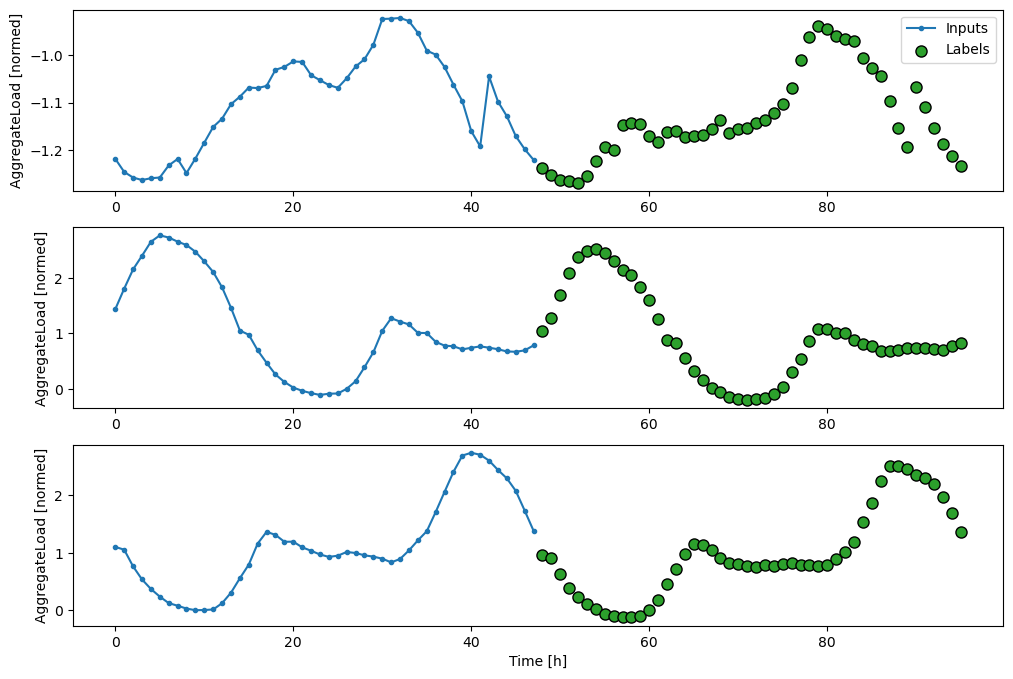

In [90]:
# Prepare data for one-shot multi-step
OUT_STEPS = 48 # 24 hour forecast
# IN_STEPS = 336 # look back 1 week
IN_STEPS = 48 # look back 1 day
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['AggregateLoad'],
                              train_df=train_data, val_df=val_data, test_df=test_data,)

num_out_features = multi_window.num_out_features
print('\nnum_out_features: ', num_out_features)
multi_window.plot()
multi_window

# Build and Train models

## Baseline persistence model

Use a 1 week naive persistence model as a baseline to evaluate performance of the machine learning models we are building

Georgios Tziolis, Chrysovalantis Spanias, Maria Theodoride, Spyros Theocharides, Javier Lopez-Lorente, Andreas Livera, George Makrides, George E. Georghiou,

Short-term electric net load forecasting for solar-integrated distribution systems based on Bayesian neural networks and statistical post-processing,

Energy,
Volume 271,
2023,
127018,
ISSN 0360-5442,

https://doi.org/10.1016/j.energy.2023.127018.

In [91]:
# capture performnce of models
multi_val_performance = {}
multi_test_performance = {}

### Function to compile and fit models

In [92]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=5):
  # https://www.tensorflow.org/tutorials/structured_data/time_series#linear_model
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  checkpoint_filepath = '/tmp/' + model.name + '/checkpoint'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)
    
  print('\nwindow.train:\n', window.train)  
  print('\nwindow.val:\n', window.val)  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping, checkpoint])

  # restore weights from epoch with best loss against validation dataset
  model.load_weights(checkpoint_filepath)
    
  return history


In [93]:
# Baseline Model: Naive 1 week persistence
OneWeekNPeriods = 48 * 7
NaiveForecast = mergeData.AggregateLoad.shift(OneWeekNPeriods).copy()

print(NaiveForecast.info())
print(NaiveForecast.describe())

<class 'pandas.core.series.Series'>
RangeIndex: 39223 entries, 0 to 39222
Series name: AggregateLoad
Non-Null Count  Dtype  
--------------  -----  
38887 non-null  float64
dtypes: float64(1)
memory usage: 306.6 KB
None
count    38887.000000
mean       901.145672
std        515.040510
min          7.664000
25%        537.285350
50%        878.142433
75%       1224.538267
max       2608.409794
Name: AggregateLoad, dtype: float64


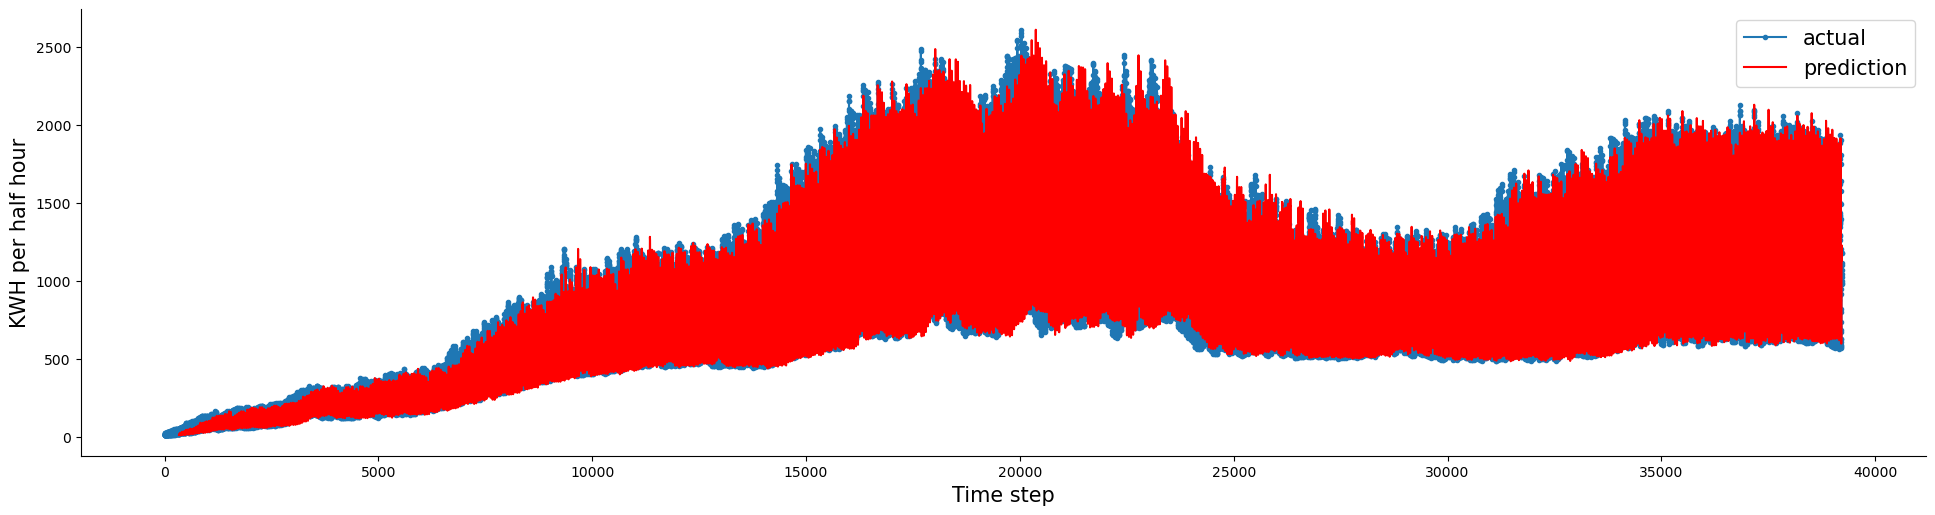

In [94]:
# visualize naive forecast and actuals for entire dataset
prediction_plot(mergeData.AggregateLoad, NaiveForecast)

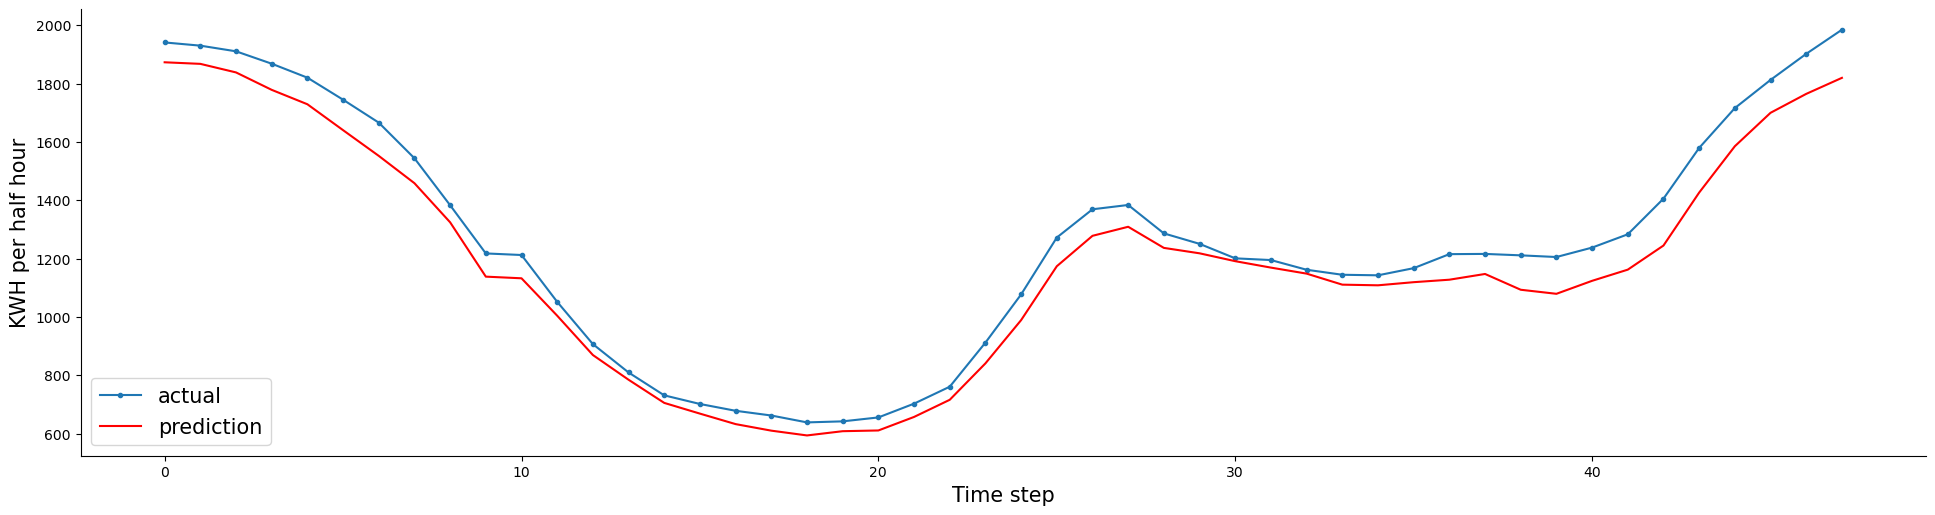

In [95]:
# visualize naive forecast and actuals for first 24 hours of the test dataset
# print(train_size, val_size, test_size)
# print(train_size+val_size)
prediction_plot(mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS])

In [96]:
# standardize the baseline 
# (NaiveForecast - train_mean) / train_std
NaiveForecastNormed = NaiveForecast.transform(lambda x: (x - train_mean) / train_std)
NaiveForecastNormed.describe()

AggregateLoad  weekOfYear_sin  weekOfYear_cos  dayOfWeek_sin  \
count   38887.000000    38887.000000    38887.000000   38887.000000   
mean        0.123737     1349.947582     1254.857154    1274.325212   
std         0.936022      771.711161      717.243809     728.325804   
min        -1.500056       11.198951       10.597363      10.840604   
25%        -0.537534      804.757318      748.146404     759.785372   
50%         0.081931     1315.480669     1222.822915    1241.796018   
75%         0.711463     1834.503010     1705.212674    1731.639088   
max         3.226478     3908.027484     3632.387849    3688.590674   

       dayOfWeek_cos    dailyTrend  dailySeasonal    dailyResid   weeklyTrend  \
count   38887.000000  38887.000000   38887.000000  38887.000000  38887.000000   
mean     1274.469377      0.146062       3.471403      5.260502      0.146760   
std       728.408175      1.105714       1.984045      3.006419      1.109636   
min        10.841873     -1.772107       0.029523      0.045028     -1.778214   
25%       759.871344     -0.635091       2.069737      3.136559     -0.637164   
50%      1241.936504      0.096678       3.382790      5.126226      0.097200   
75%      1731.834973      0.840337       4.717180      7.148225      0.843498   
max      3689.007883      3.811299      10.048145     15.226226      3.824999   

       weeklySeasonal   weeklyResid  AggregateLoad_1dayLag  \
count    38887.000000  38887.000000           38887.000000   
mean         3.405937      5.326744               0.126728   
std          1.946680      3.044478               0.934540   
min          0.028877      0.045246              -1.494492   
25%          2.030667      3.175913              -0.533496   
50%          3.318992      5.190768               0.084989   
75%          4.628252      7.238363               0.713523   
max          9.858820     15.418626               3.224555   

       AggregateLoad_1weekLag  AggregateLoad_halfhourdiff   temperature  \
count            38887.000000                38887.000000  38887.000000   
mean                 0.142421                   14.219262    155.232251   
std                  0.924895                    8.127191     89.696798   
min                 -1.462067                    0.120379     -0.371908   
25%                 -0.510989                    8.477651     91.864215   
50%                  0.101112                   13.856277    151.226126   
75%                  0.723160                   19.322303    211.552637   
max                  3.208276                   41.159396    452.560564   

        temp_daymax  
count  38887.000000  
mean     144.990075  
std       84.072924  
min       -0.857902  
25%       85.595133  
50%      141.235129  
75%      197.779245  
max      423.676284

In [97]:
# calculate error for baseline naive model (Normed)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# calculate error for naive model on validation set
valNaiveMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size:train_size+val_size], NaiveForecastNormed.AggregateLoad[train_size:train_size+val_size])

# calculate error for naive model on test set
testNaiveMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size+val_size:], NaiveForecastNormed.AggregateLoad[train_size+val_size:])

print('valNaiveMAE: ', valNaiveMAE)
print('testNaiveMAE: ', testNaiveMAE)

valNaiveMAE:  0.08646842339205185
testNaiveMAE:  0.1140271504467229


In [98]:
# calculate error for baseline naive model (not normed)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print('Naive Root Mean Squared Error(RMSE): %.2f; Naive Mean Absolute Error(MAE) : %.2f; Naive Mean Absolute Percantage Error(MAPE) : %.2f '
      % (np.sqrt(mean_squared_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])),
         mean_absolute_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:]),
         mean_absolute_percentage_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])))

# calculate error for naive model on validation set
valNaiveMAE = mean_absolute_error(mergeData.AggregateLoad[train_size:train_size+val_size], NaiveForecast[train_size:train_size+val_size])

# calculate error for naive model on test set
testNaiveMAE = mean_absolute_error(mergeData.AggregateLoad[train_size+val_size:], NaiveForecast[train_size+val_size:])

print('valNaiveMAE: ', valNaiveMAE)
print('testNaiveMAE: ', testNaiveMAE)


Naive Root Mean Squared Error(RMSE): 93.05; Naive Mean Absolute Error(MAE) : 60.61; Naive Mean Absolute Percantage Error(MAPE) : 0.08 
valNaiveMAE:  47.578708576825825
testNaiveMAE:  62.74272558841627


In [99]:
# function for plotting the train and test loss curves
def plot_model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()
    return

In [100]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Baseline'] = repeat_baseline.evaluate(mergeDataNormed.AggregateLoad[train_size:train_size+val_size], NaiveForecastNormed.AggregateLoad[train_size:train_size+val_size], verbose=0)
multi_test_performance['Baseline'] = repeat_baseline.evaluate(mergeDataNormed.AggregateLoad[train_size+val_size:], NaiveForecastNormed.AggregateLoad[train_size+val_size:], verbose=0)
print(multi_val_performance['Baseline'], multi_test_performance['Baseline'])

[0.016328072175383568, 0.0864684134721756] [0.032646629959344864, 0.11402714252471924]


## Multi Layer Perceptron (MLP) Model


window.train:
 <_MapDataset element_spec=(TensorSpec(shape=(None, 48, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>

window.val:
 <_MapDataset element_spec=(TensorSpec(shape=(None, 48, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>
Epoch 1/100
852/856 [============================>.] - ETA: 0s - loss: 0.1670 - mean_absolute_error: 0.2704
Epoch 1: val_loss improved from inf to 0.09153, saving model to /tmp/MLP/checkpoint
856/856 [==============================] - 6s 6ms/step - loss: 0.1667 - mean_absolute_error: 0.2702 - val_loss: 0.0915 - val_mean_absolute_error: 0.2217
Epoch 2/100
847/856 [============================>.] - ETA: 0s - loss: 0.0764 - mean_absolute_error: 0.1842
Epoch 2: val_loss improved from 0.09153 to 0.07258, saving model to /tmp/MLP/checkpoint
856/856 [==============================] - 4s 5ms/step - loss: 0.0764 - mean_absolute_error: 0.1841 - val_loss: 0.0726 - va

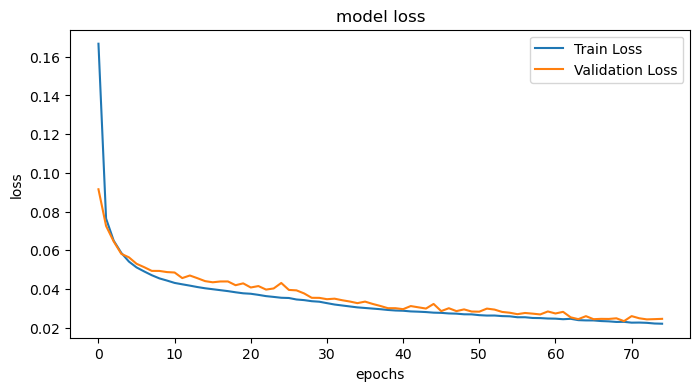

243/243 [==============================] - 1s 3ms/step - loss: 0.0234 - mean_absolute_error: 0.1140


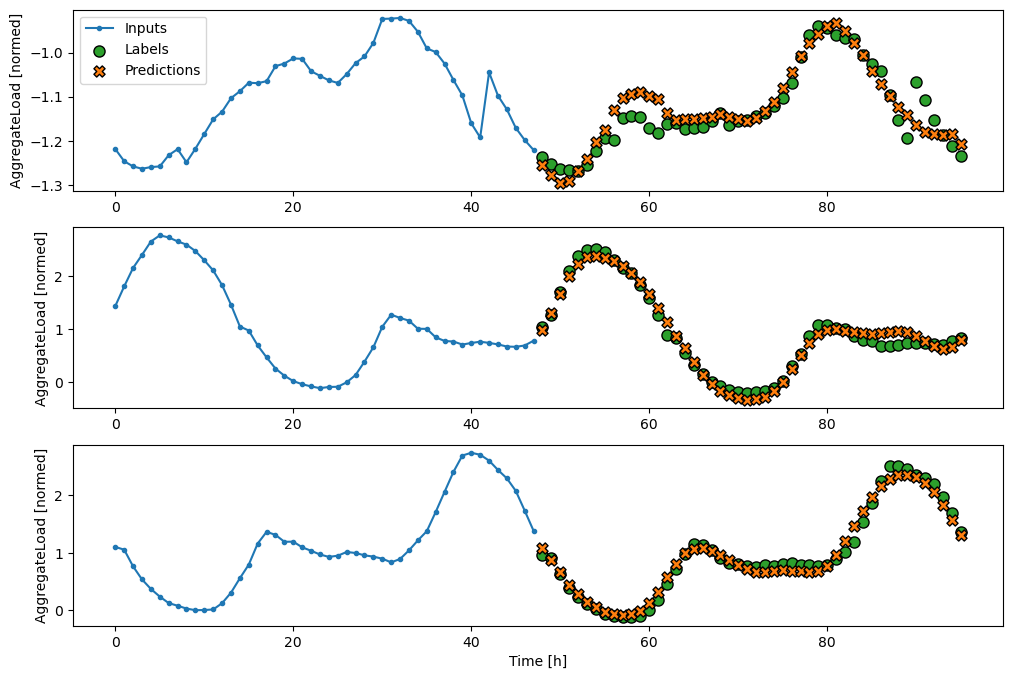

In [101]:
multi_MLP_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="MLP")

history = compile_and_fit(multi_MLP_model, multi_window)
multi_MLP_model.save('multi_MLP_model.keras')
plot_model_loss(history)

# IPython.display.clear_output()
multi_val_performance['MLP'] = multi_MLP_model.evaluate(multi_window.val)
multi_test_performance['MLP'] = multi_MLP_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_MLP_model)

In [102]:
num_out_features

1

## Convolutional Neural Network (CNN) Model




window.train:
 <_MapDataset element_spec=(TensorSpec(shape=(None, 48, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>

window.val:
 <_MapDataset element_spec=(TensorSpec(shape=(None, 48, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>
Epoch 1/100
853/856 [============================>.] - ETA: 0s - loss: 0.0749 - mean_absolute_error: 0.1738
Epoch 1: val_loss improved from inf to 0.03132, saving model to /tmp/CNN/checkpoint
856/856 [==============================] - 7s 7ms/step - loss: 0.0748 - mean_absolute_error: 0.1737 - val_loss: 0.0313 - val_mean_absolute_error: 0.1349
Epoch 2/100
845/856 [============================>.] - ETA: 0s - loss: 0.0276 - mean_absolute_error: 0.1188
Epoch 2: val_loss improved from 0.03132 to 0.02711, saving model to /tmp/CNN/checkpoint
856/856 [==============================] - 5s 6ms/step - loss: 0.0275 - mean_absolute_error: 0.1187 - val_loss: 0.0271 - va

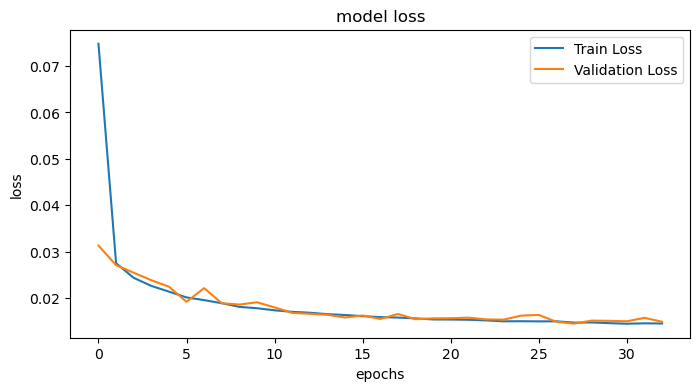

243/243 [==============================] - 1s 3ms/step - loss: 0.0145 - mean_absolute_error: 0.0915


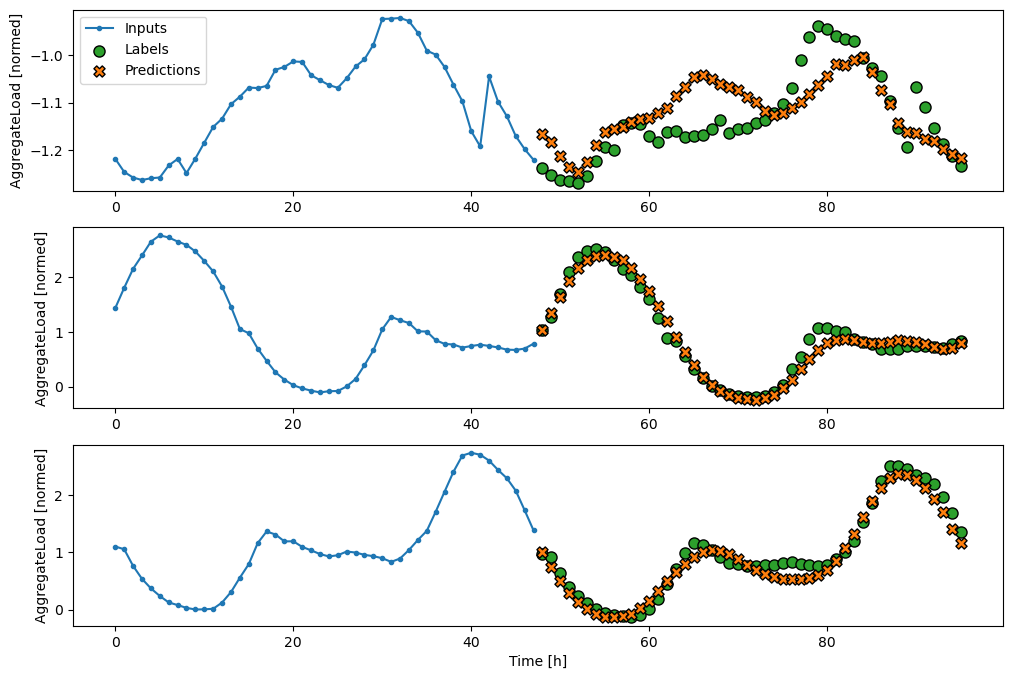

In [103]:
CONV_WIDTH = 10
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="CNN")

history = compile_and_fit(multi_conv_model, multi_window)
multi_conv_model.save('multi_conv_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_test_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)


## Recurrent Neural Network (RNN) Model


window.train:
 <_MapDataset element_spec=(TensorSpec(shape=(None, 48, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>

window.val:
 <_MapDataset element_spec=(TensorSpec(shape=(None, 48, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>
Epoch 1/100
855/856 [============================>.] - ETA: 0s - loss: 0.1227 - mean_absolute_error: 0.2314
Epoch 1: val_loss improved from inf to 0.02979, saving model to /tmp/RNN/checkpoint
856/856 [==============================] - 28s 30ms/step - loss: 0.1227 - mean_absolute_error: 0.2314 - val_loss: 0.0298 - val_mean_absolute_error: 0.1351
Epoch 2/100
856/856 [==============================] - ETA: 0s - loss: 0.0231 - mean_absolute_error: 0.1109
Epoch 2: val_loss improved from 0.02979 to 0.02243, saving model to /tmp/RNN/checkpoint
856/856 [==============================] - 25s 30ms/step - loss: 0.0231 - mean_absolute_error: 0.1109 - val_loss: 0.0224 

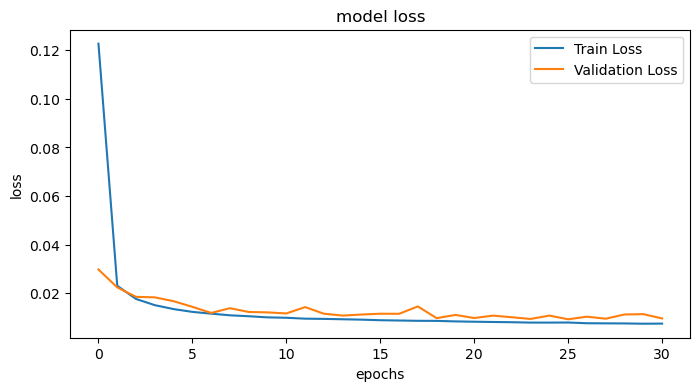

243/243 [==============================] - 2s 10ms/step - loss: 0.0093 - mean_absolute_error: 0.0739


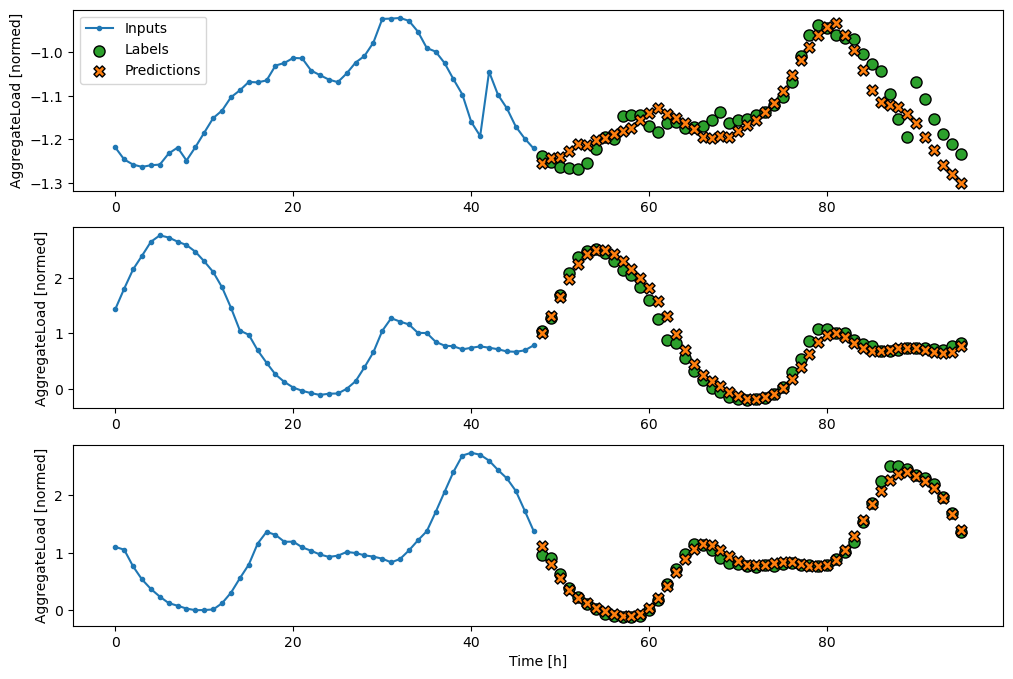

In [104]:
multi_rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.SimpleRNN(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="RNN")

history = compile_and_fit(multi_rnn_model, multi_window)
plot_model_loss(history)
multi_rnn_model.save('multi_rnn_model.keras')
# IPython.display.clear_output()

multi_val_performance['RNN'] = multi_rnn_model.evaluate(multi_window.val)
multi_test_performance['RNN'] = multi_rnn_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_rnn_model)

## Long Short Term Memory (LSTM) Model


window.train:
 <_MapDataset element_spec=(TensorSpec(shape=(None, 48, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>

window.val:
 <_MapDataset element_spec=(TensorSpec(shape=(None, 48, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>
Epoch 1/100
856/856 [==============================] - ETA: 0s - loss: 0.1342 - mean_absolute_error: 0.2313
Epoch 1: val_loss improved from inf to 0.02311, saving model to /tmp/LSTM/checkpoint
856/856 [==============================] - 56s 60ms/step - loss: 0.1342 - mean_absolute_error: 0.2313 - val_loss: 0.0231 - val_mean_absolute_error: 0.1164
Epoch 2/100
856/856 [==============================] - ETA: 0s - loss: 0.0158 - mean_absolute_error: 0.0905
Epoch 2: val_loss improved from 0.02311 to 0.01700, saving model to /tmp/LSTM/checkpoint
856/856 [==============================] - 49s 57ms/step - loss: 0.0158 - mean_absolute_error: 0.0905 - val_loss: 0.017

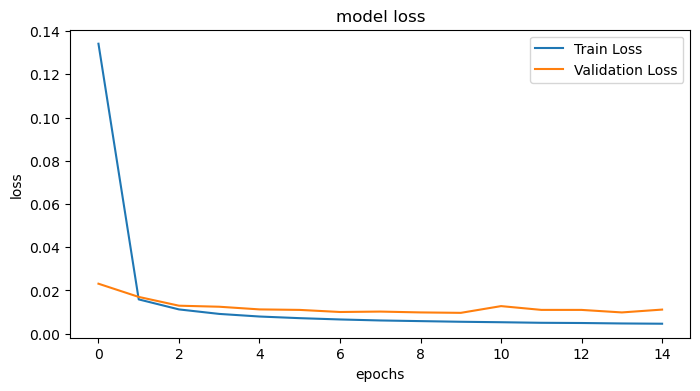

243/243 [==============================] - 4s 15ms/step - loss: 0.0096 - mean_absolute_error: 0.0714


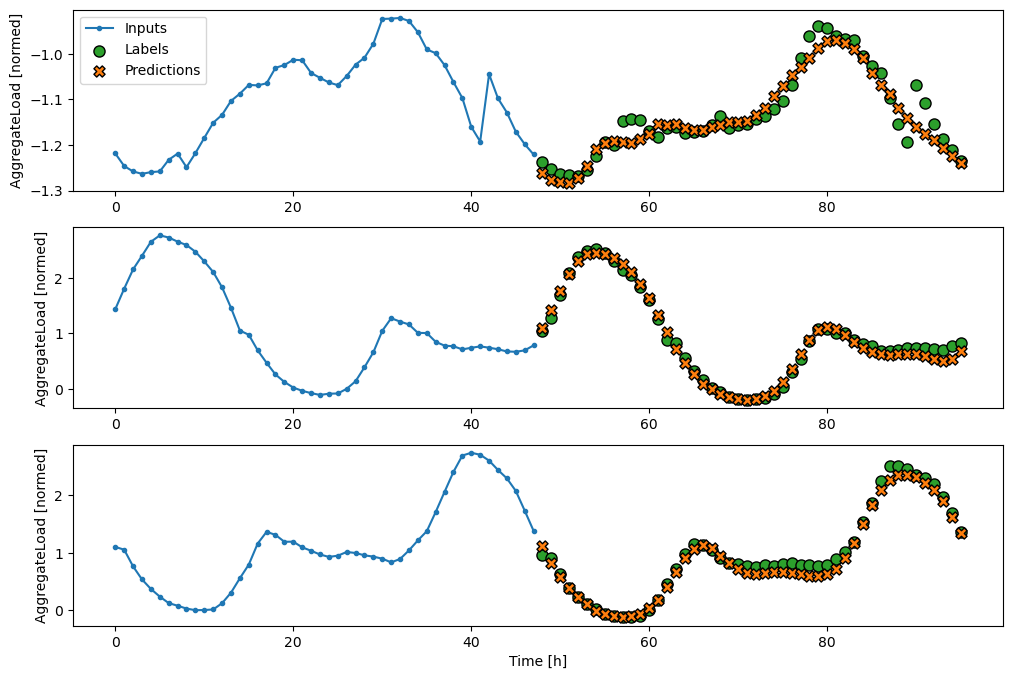

In [105]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.LSTM(32,return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="LSTM")

start_time = time.time()
history = compile_and_fit(multi_lstm_model, multi_window)
print('%s seconds' % (time.time() - start_time))
multi_lstm_model.save('multi_lstm_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_test_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


# GRU Model


window.train:
 <_MapDataset element_spec=(TensorSpec(shape=(None, 48, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>

window.val:
 <_MapDataset element_spec=(TensorSpec(shape=(None, 48, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>
Epoch 1/100
855/856 [============================>.] - ETA: 0s - loss: 0.1060 - mean_absolute_error: 0.2034
Epoch 1: val_loss improved from inf to 0.02254, saving model to /tmp/GRU/checkpoint
856/856 [==============================] - 60s 63ms/step - loss: 0.1059 - mean_absolute_error: 0.2034 - val_loss: 0.0225 - val_mean_absolute_error: 0.1164
Epoch 2/100
856/856 [==============================] - ETA: 0s - loss: 0.0164 - mean_absolute_error: 0.0914
Epoch 2: val_loss improved from 0.02254 to 0.01692, saving model to /tmp/GRU/checkpoint
856/856 [==============================] - 57s 66ms/step - loss: 0.0164 - mean_absolute_error: 0.0914 - val_loss: 0.0169 

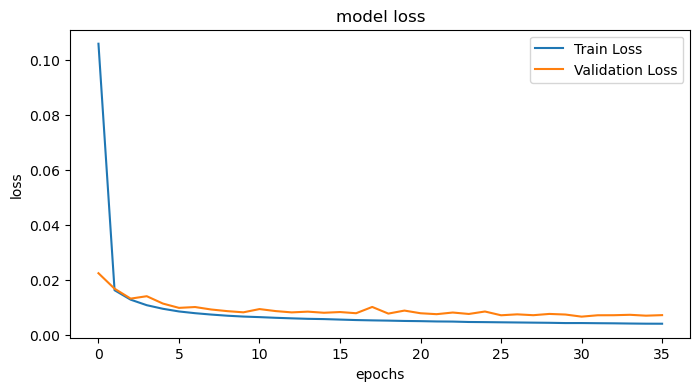

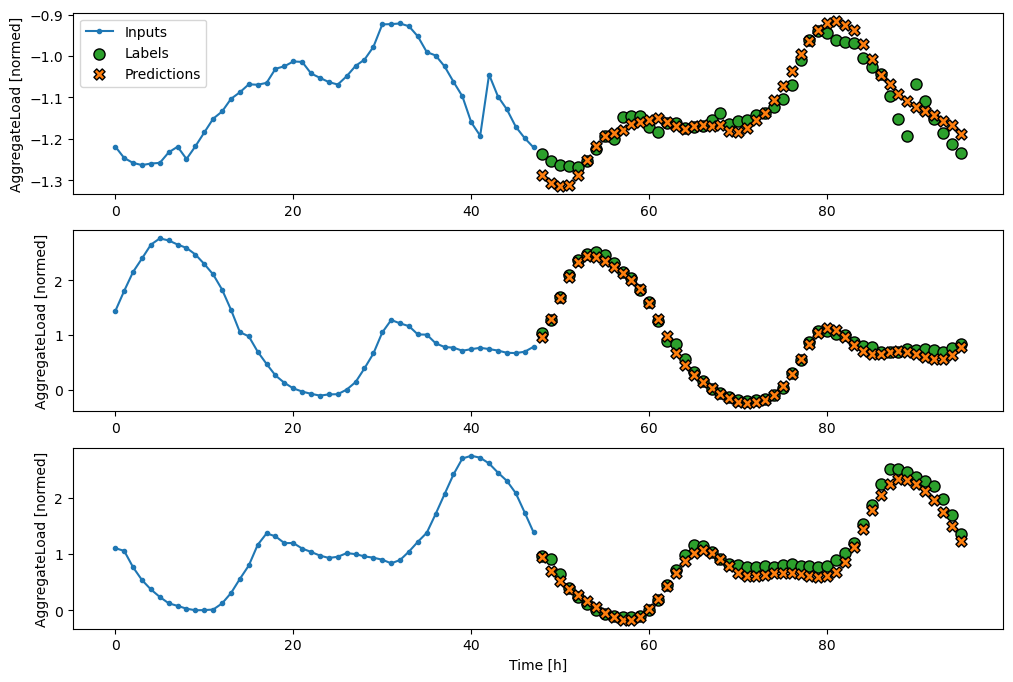

In [106]:
multi_gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="GRU")

start_time = time.time()
history = compile_and_fit(multi_gru_model, multi_window)
print('%s seconds' % (time.time() - start_time))
multi_gru_model.save('multi_gru_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['GRU'] = multi_gru_model.evaluate(multi_window.val, verbose=0)
multi_test_performance['GRU'] = multi_gru_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_gru_model)

# Model Evaluation and Selection

print('\nValidation Performance:\n', multi_val_performance)
print('\nTest Performance:\n', multi_test_performance)

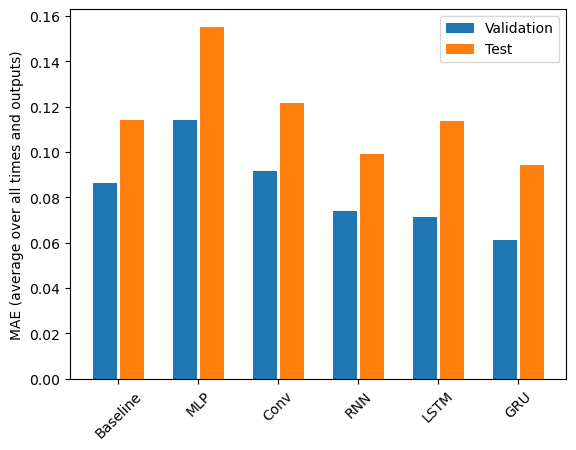

In [107]:
x = np.arange(len(multi_test_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_test_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_test_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()
plt.savefig('model performance.png', format='png')


In [108]:
CONV_WIDTH = 10 # CNN model would not load without this...
# restore models from file
multi_MLP_model = tf.keras.models.load_model('multi_MLP_model.keras')
multi_conv_model = tf.keras.models.load_model('multi_conv_model.keras')
multi_rnn_model = tf.keras.models.load_model('multi_rnn_model.keras')
multi_lstm_model = tf.keras.models.load_model('multi_lstm_model.keras')
multi_gru_model = tf.keras.models.load_model('multi_gru_model.keras')
model_list = [multi_MLP_model, multi_conv_model, multi_rnn_model, multi_lstm_model, multi_gru_model]


In [109]:
for model in model_list:
    print(model.name)

MLP
CNN
RNN
LSTM
GRU


In [110]:
# store the evaluation results for all models
import pickle
with open('model eval results.pkl', 'wb') as f:
    pickle.dump(multi_val_performance, f)

with open('model test results.pkl', 'wb') as f:
    pickle.dump(multi_test_performance, f)

In [111]:
# load the evaluation results for all models
with open('model eval results.pkl', 'rb') as f:
    multi_val_performance = pickle.load(f)

with open('model test results.pkl', 'rb') as f:
    multi_test_performance = pickle.load(f)

print(multi_val_performance)
print(multi_test_performance)

{'Baseline': [0.016328072175383568, 0.0864684134721756], 'MLP': [0.023401085287332535, 0.11401147395372391], 'Conv': [0.014522778801620007, 0.09154875576496124], 'RNN': [0.0093033192679286, 0.07393228262662888], 'LSTM': [0.009625176899135113, 0.07142414152622223], 'GRU': [0.006762123201042414, 0.06105507165193558]}
{'Baseline': [0.032646629959344864, 0.11402714252471924], 'MLP': [0.044436901807785034, 0.1551814079284668], 'Conv': [0.02713417448103428, 0.12164919823408127], 'RNN': [0.017603078857064247, 0.09900355339050293], 'LSTM': [0.025847602635622025, 0.1137462854385376], 'GRU': [0.016563454642891884, 0.0944320410490036]}


## Feature Evaluation (methods that require models already built)

In [112]:
# function to create time series dataset for feature permutation
def generateFeatPermWindow(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=None,
                                cols_to_shuffle=None,
                              train_df=train_data, val_df=val_data, test_df=test_data):
    
    train = train_df.copy()
    val = val_df.copy()
    test = test_df.copy()
    
    # randomly shuffle shuffle the specified columns
    for col in cols_to_shuffle:
        # print('\nShuffling: ', col)
        # print('\nTrain Before:\n', train[col])
        train[col] = train[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)
        # print('\nShuffle:\n', train[col].sample(frac=1, replace=False, random_state=randomState))
        # print('\nAfter:\n', train[col])
        # print('\nVal Before:\n', val[col])
        val[col] = val[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)
        # print('\nShuffle:\n', val[col].sample(frac=1, replace=False, random_state=randomState))
        # print('\nAfter:\n', val[col])
        # print('\nTest Before:\n', test[col])
        test[col] = test[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)
        # print('\nShuffle:\n', test[col].sample(frac=1, replace=False, random_state=randomState))
        # print('\nAfter:\n', test[col])
    
    """
    print('train NaNs: ', train.isnull().sum().sum())
    print('val NaNs: ', val.isnull().sum().sum())
    print('val NaNs:\n', val[val.isna().any(axis=1)])
    print('test NaNs: ', test.isnull().sum().sum())
    print('test NaNs:\n', test[test.isna().any(axis=1)])
    """

    feat_perm_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=label_columns,
                              train_df=train, val_df=val, test_df=test,)
    
    return feat_perm_window


In [113]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Define a function to calculate the permutation importance of a feature group for a given model
def calculate_permutation_importance_group(model, feature_group, baseline_val_perf, baseline_test_perf):
    """Calculates the permutation importance of a feature group for a given model.

    Args:
        model: The model to calculate the permutation importance for.
        feature_group: A list of the features in the feature group.

    Returns:
        The permutation importance of the feature group for the given model.
    """

    # Shuffle the values of the features in the feature group
    feat_perm_window = generateFeatPermWindow(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=label_columns,
                                cols_to_shuffle=feature_group,
                              train_df=train_data, val_df=val_data, test_df=test_data)
    
    # model.fit(X_shuffled, y)
    val_perf_shuffle = multi_gru_model.evaluate(feat_perm_window.val, verbose=1)[1] # MAE

    # Calculate the permutation importance
    # importance = np.mean(y - y_pred)
    importance = val_perf_shuffle - baseline_val_perf
    
    print('\nModel: ', model.name, feature_group, 'importance: ', importance)

    return importance

In [114]:
# Update the function to visualize the permutation importances for a given feature to include feature groups
def visualize_permutation_importances(model, permutation_importances, feature_groups):
    """Visualizes the permutation importances for a given feature, including feature groups.

    Args:
        feature: The feature to visualize the permutation importances for.
        permutation_importances: A dictionary mapping the model names to the permutation importances for the given feature.
        feature_groups: A dictionary mapping the feature group names to the lists of features in the feature groups.
    """

    # Create a bar chart of the permutation importances
    plt.bar(permutation_importances.keys(), permutation_importances.values())
    plt.xlabel('Model')
    plt.ylabel('Permutation Importance')
    plt.title('Permutation Importances for Feature: {}'.format(feature))

    # Add labels for the feature groups
    for feature_group_name, feature_group in feature_groups.items():
        if feature_group_name in permutation_importances:
            plt.text(permutation_importances.keys().index(feature_group_name), permutation_importances[feature_group_name], feature_group_name, ha='center', va='bottom')

    plt.show()

In [115]:
# Define a function to visualize the permutation importances for a given feature using a stacked bar chart
def visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances):
    """Visualizes the permutation importances for a given feature using a stacked bar chart created with the plt.stackplot() function.

    Args:
        feature: The feature to visualize the permutation importances for.
        permutation_importances: A dictionary mapping the model names to the permutation importances for the given feature.
    """

    # Get the permutation importances for each feature in a list
    importances = sorted(permutation_importances.items(), key=itemgetter(1), reverse=True)
    permutation_importances_values = list(importances.values())

    # Create a stacked bar chart of the permutation importances
    plt.bar(importances.keys(), permutation_importances_values)
    plt.xlabel('Feature')
    plt.ylabel('Permutation Importance')
    plt.title('Permutation Importances for Model: {}'.format(model))
    plt.legend(importances.keys())
    plt.tick_params(rotation=45)
    plt.show()

In [116]:
# Update the main code to calculate the permutation importance of each feature group for each model and visualize the results
feature_groups = {
    'weekOfYear': ['weekOfYear_sin', 'weekOfYear_cos'],
    'dayOfWeek': ['dayOfWeek_sin', 'dayOfWeek_cos'],
#    'minuteOfDay': ['minuteOfDay_sin', 'minuteOfDay_cos'],
}

grouped_features = [value for key, value in feature_groups.items() for value in value]
print('grouped_features: ', grouped_features, '\n')

# individual features
for feature in val_data.columns:
    if feature not in grouped_features:
        feature_groups[feature] = [feature]

print('feature_groups: ', feature_groups)

permutation_importances_groups = {}
for model in model_list:
    # calculate baseline model performance with all features
    print('\ncalculate baseline model performance with all features.\n', model.name)
    val_perf = model.evaluate(multi_window.val, verbose=1)[1] # MAE
    test_perf = model.evaluate(multi_window.test, verbose=1)[1] # MAE

    for feature_group_name, feature_group in feature_groups.items():
        permutation_importance = calculate_permutation_importance_group(model, feature_group, val_perf, test_perf)
        if model.name not in permutation_importances_groups:
            permutation_importances_groups[model.name] = {}
        permutation_importances_groups[model.name][feature_group_name] = permutation_importance


grouped_features:  ['weekOfYear_sin', 'weekOfYear_cos', 'dayOfWeek_sin', 'dayOfWeek_cos'] 

feature_groups:  {'weekOfYear': ['weekOfYear_sin', 'weekOfYear_cos'], 'dayOfWeek': ['dayOfWeek_sin', 'dayOfWeek_cos'], 'AggregateLoad': ['AggregateLoad'], 'dailyTrend': ['dailyTrend'], 'dailySeasonal': ['dailySeasonal'], 'dailyResid': ['dailyResid'], 'weeklyTrend': ['weeklyTrend'], 'weeklySeasonal': ['weeklySeasonal'], 'weeklyResid': ['weeklyResid'], 'AggregateLoad_1dayLag': ['AggregateLoad_1dayLag'], 'AggregateLoad_1weekLag': ['AggregateLoad_1weekLag'], 'AggregateLoad_halfhourdiff': ['AggregateLoad_halfhourdiff'], 'temperature': ['temperature'], 'temp_daymax': ['temp_daymax']}

calculate baseline model performance with all features.
 MLP
243/243 [==============================] - 5s 17ms/step - loss: 0.0118 - mean_absolute_error: 0.0808

Model:  MLP ['weekOfYear_sin', 'weekOfYear_cos'] importance:  -0.03317735344171524
243/243 [==============================] - 4s 14ms/step - loss: 0.0127 - mea

In [117]:
permutation_importances_groups

{'MLP': {'weekOfYear': -0.03317735344171524,
  'dayOfWeek': -0.0335991308093071,
  'AggregateLoad': 0.5318750664591789,
  'dailyTrend': -0.01843884587287903,
  'dailySeasonal': 0.15139614790678024,
  'dailyResid': 0.008127711713314056,
  'weeklyTrend': -0.016108877956867218,
  'weeklySeasonal': 0.060785792768001556,
  'weeklyResid': -0.021191991865634918,
  'AggregateLoad_1dayLag': -0.03922394663095474,
  'AggregateLoad_1weekLag': -0.042599014937877655,
  'AggregateLoad_halfhourdiff': 0.11736757308244705,
  'temperature': -0.0430404469370842,
  'temp_daymax': -0.04001743346452713},
 'CNN': {'weekOfYear': -0.010714635252952576,
  'dayOfWeek': -0.011136412620544434,
  'AggregateLoad': 0.5543377846479416,
  'dailyTrend': 0.0040238723158836365,
  'dailySeasonal': 0.1738588660955429,
  'dailyResid': 0.03059042990207672,
  'weeklyTrend': 0.006353840231895447,
  'weeklySeasonal': 0.08324851095676422,
  'weeklyResid': 0.0012707263231277466,
  'AggregateLoad_1dayLag': -0.016761228442192078,
  '

In [118]:
from operator import itemgetter, attrgetter
# Define a function to visualize the permutation importances for a given feature using a stacked bar chart
def visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances):
    """Visualizes the permutation importances for a given feature using a stacked bar chart created with the plt.stackplot() function.

    Args:
        feature: The feature to visualize the permutation importances for.
        permutation_importances: A dictionary mapping the model names to the permutation importances for the given feature.
    """

    # Get the permutation importances for each feature in a list
    importances = sorted(permutation_importances.items(), key=itemgetter(1), reverse=True)
    print(importances)
    df = pd.DataFrame(importances, columns=['label', 'value'])
    labels = df['label'].tolist()
    values = df['value'].tolist()


    # Create a stacked bar chart of the permutation importances
    plt.bar(labels, values)
    plt.xlabel('Feature')
    plt.ylabel('Permutation Importance')
    plt.title('Permutation Importances for Model: {}'.format(model))
    plt.legend(labels)
    plt.tick_params(rotation=90)
    plt.show()

[('AggregateLoad', 0.5318750664591789), ('dailySeasonal', 0.15139614790678024), ('AggregateLoad_halfhourdiff', 0.11736757308244705), ('weeklySeasonal', 0.060785792768001556), ('dailyResid', 0.008127711713314056), ('weeklyTrend', -0.016108877956867218), ('dailyTrend', -0.01843884587287903), ('weeklyResid', -0.021191991865634918), ('weekOfYear', -0.03317735344171524), ('dayOfWeek', -0.0335991308093071), ('AggregateLoad_1dayLag', -0.03922394663095474), ('temp_daymax', -0.04001743346452713), ('AggregateLoad_1weekLag', -0.042599014937877655), ('temperature', -0.0430404469370842)]


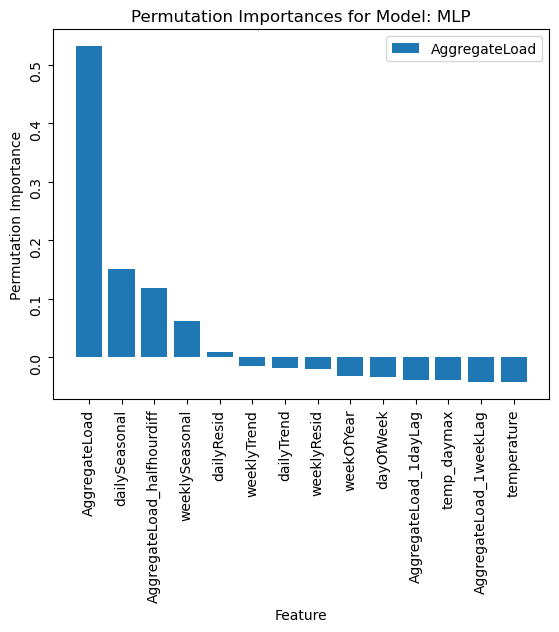

[('AggregateLoad', 0.5543377846479416), ('dailySeasonal', 0.1738588660955429), ('AggregateLoad_halfhourdiff', 0.13983029127120972), ('weeklySeasonal', 0.08324851095676422), ('dailyResid', 0.03059042990207672), ('weeklyTrend', 0.006353840231895447), ('dailyTrend', 0.0040238723158836365), ('weeklyResid', 0.0012707263231277466), ('weekOfYear', -0.010714635252952576), ('dayOfWeek', -0.011136412620544434), ('AggregateLoad_1dayLag', -0.016761228442192078), ('temp_daymax', -0.017554715275764465), ('AggregateLoad_1weekLag', -0.02013629674911499), ('temperature', -0.020577728748321533)]


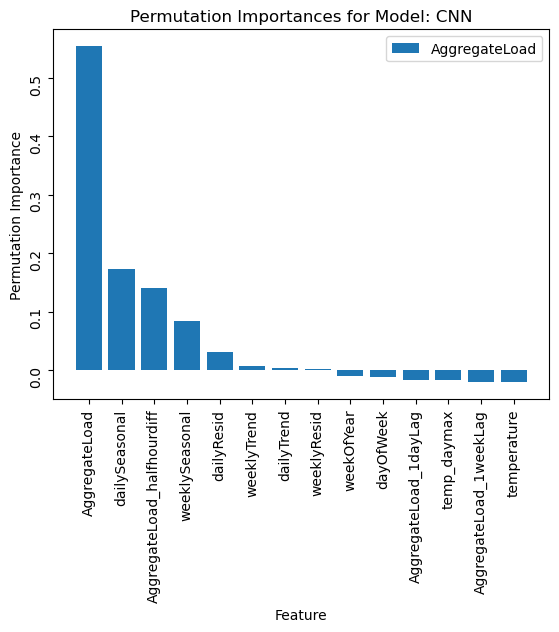

[('AggregateLoad', 0.571954257786274), ('dailySeasonal', 0.19147533923387527), ('AggregateLoad_halfhourdiff', 0.15744676440954208), ('weeklySeasonal', 0.10086498409509659), ('dailyResid', 0.04820690304040909), ('weeklyTrend', 0.023970313370227814), ('dailyTrend', 0.021640345454216003), ('weeklyResid', 0.018887199461460114), ('weekOfYear', 0.006901837885379791), ('dayOfWeek', 0.006480060517787933), ('AggregateLoad_1dayLag', 0.0008552446961402893), ('temp_daymax', 6.175786256790161e-05), ('AggregateLoad_1weekLag', -0.0025198236107826233), ('temperature', -0.0029612556099891663)]


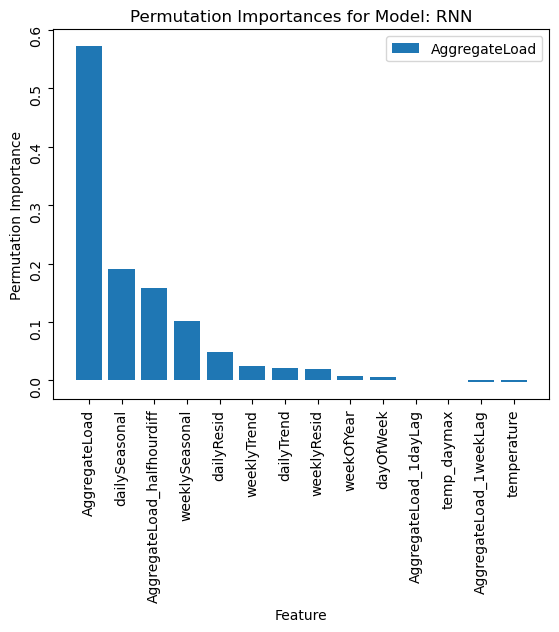

[('AggregateLoad', 0.5744623988866806), ('dailySeasonal', 0.19398348033428192), ('AggregateLoad_halfhourdiff', 0.15995490550994873), ('weeklySeasonal', 0.10337312519550323), ('dailyResid', 0.050715044140815735), ('weeklyTrend', 0.02647845447063446), ('dailyTrend', 0.02414848655462265), ('weeklyResid', 0.02139534056186676), ('weekOfYear', 0.009409978985786438), ('dayOfWeek', 0.00898820161819458), ('AggregateLoad_1dayLag', 0.003363385796546936), ('temp_daymax', 0.0025698989629745483), ('AggregateLoad_1weekLag', -1.1682510375976562e-05), ('temperature', -0.00045311450958251953)]


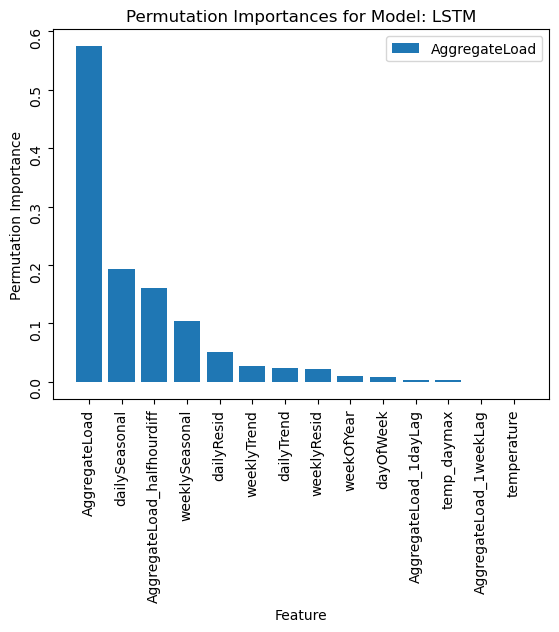

[('AggregateLoad', 0.5848314687609673), ('dailySeasonal', 0.20435255020856857), ('AggregateLoad_halfhourdiff', 0.17032397538423538), ('weeklySeasonal', 0.11374219506978989), ('dailyResid', 0.061084114015102386), ('weeklyTrend', 0.03684752434492111), ('dailyTrend', 0.0345175564289093), ('weeklyResid', 0.03176441043615341), ('weekOfYear', 0.01977904886007309), ('dayOfWeek', 0.01935727149248123), ('AggregateLoad_1dayLag', 0.013732455670833588), ('temp_daymax', 0.0129389688372612), ('AggregateLoad_1weekLag', 0.010357387363910675), ('temperature', 0.009915955364704132)]


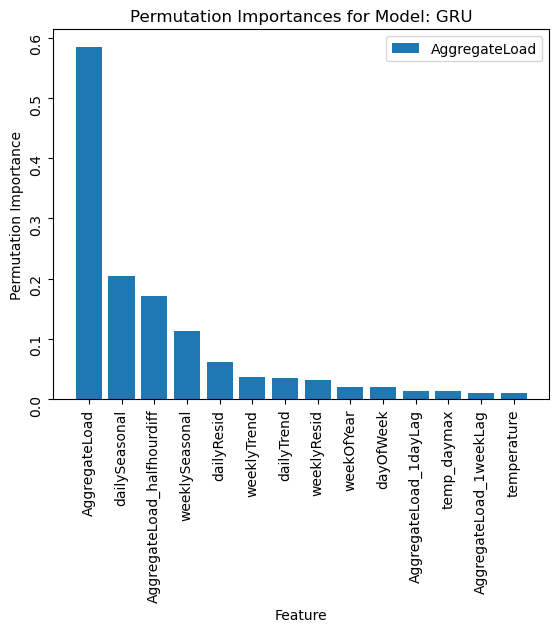

In [119]:
# Visualize the permutation importances for each feature using a stacked bar chart
for model, permutation_importances in permutation_importances_groups.items():
    visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances)

# Winning Model Results

## Single Day results: Benchmark, GRU model and actuals

In [120]:
# build a single record dataset from start of the test dataset
# print(mergeDataNormed)
# print(train_size+test_size-IN_STEPS)
# print(mergeDataNormed.iloc[train_size+test_size-IN_STEPS:train_size+test_size])

oneDay_ds = tf.keras.utils.timeseries_dataset_from_array(
      data=test_data[:IN_STEPS],
      targets=None,
      sequence_length=IN_STEPS,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

# get the prediction
testYhatNormed = multi_gru_model.predict(oneDay_ds)

1/1 [==============================] - 1s 866ms/step


In [121]:
# print(testYhatNormed) # prediction for all input columns
print(testYhatNormed[0,:,-1]) # prediction for target column, aggregate load

[ 2.1565008   2.144886    2.0707743   1.9581695   1.8181804   1.6333247
  1.3999491   1.1548923   0.9011559   0.6622627   0.4568395   0.2748712
  0.11201659 -0.03467411 -0.14224729 -0.24748108 -0.30508417 -0.34346378
 -0.36822936 -0.37005177 -0.3224033  -0.20822562 -0.02632132  0.2067737
  0.4410985   0.64249736  0.7559722   0.79775035  0.76706094  0.7030879
  0.61132383  0.5323751   0.4903378   0.46809623  0.48469496  0.49248177
  0.48638895  0.45605257  0.4385941   0.42940792  0.4703433   0.56810987
  0.7448693   0.96447146  1.2425194   1.5358742   1.7932433   1.9781107 ]


In [122]:
# Invert standardization
testYhat = (np.array(testYhatNormed) * np.array(train_std)) + np.array(train_mean)

# print(testYhat)
print(testYhat[0,:,-1])

[26.13058362 26.05943001 25.60541311 24.91558267 24.05799366 22.92554615
 21.49585966 19.99461352 18.4401946  16.97670701 15.71826074 14.60350177
 13.60583548 12.70719121 12.04818539 11.40351096 11.05062773 10.81550978
 10.66379295 10.65262864 10.94452865 11.64399445 12.75836135 14.18632855
 15.62182961 16.85562238 17.55078248 17.80672027 17.61871332 17.22680723
 16.66464973 16.18100059 15.92347515 15.78722075 15.88890651 15.93660941
 15.89928411 15.71343992 15.60648731 15.55021171 15.80098653 16.39991596
 17.48276473 18.82807315 20.53142704 22.32855308 23.90522576 25.03774484]


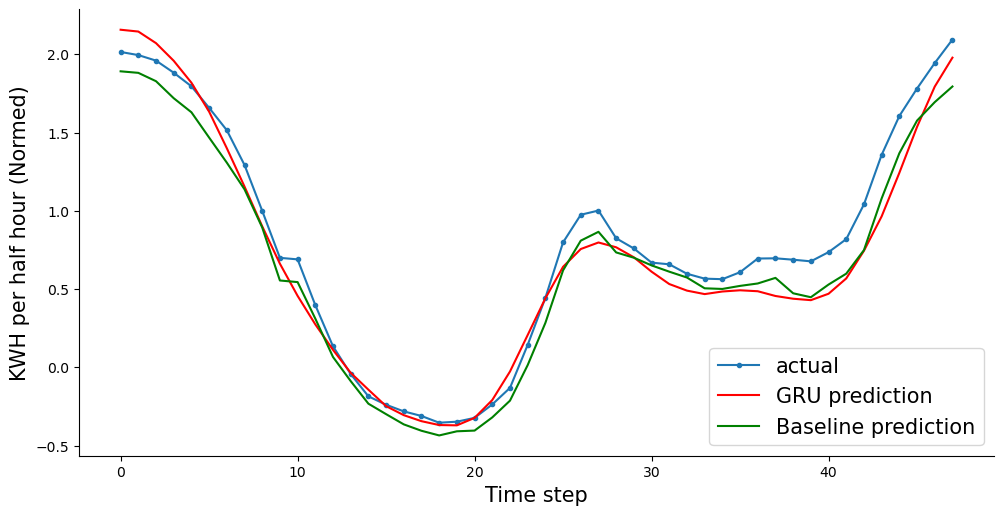

<Figure size 640x480 with 0 Axes>

In [123]:
# Plot Naive prediction, GRU prediction and Actuals for first 24 hours of the test set (normed values)
len_prediction=[x for x in range(len(testYhat[0,:,-1]))]
plt.figure(figsize=(10,5))
# plt.plot(len_prediction, test_data[:OUT_STEPS].AggregateLoad, marker='.', label="actual")
plt.plot(len_prediction, mergeDataNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], marker='.', label="actual")
plt.plot(len_prediction, testYhatNormed[0,:,-1], 'r', label="GRU prediction")
plt.plot(len_prediction, NaiveForecastNormed[train_size+val_size:train_size+val_size+OUT_STEPS].AggregateLoad, 'g', label="Baseline prediction")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('KWH per half hour (Normed)', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();
plt.savefig('Test First Day Normed.png', format='png')

In [124]:
# calculate error for baseline naive model (Normed) first 24 hours of test set
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# calculate error for baseline naive model on validation set
valBaselineMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size:train_size+OUT_STEPS], NaiveForecastNormed.AggregateLoad[train_size:train_size+OUT_STEPS])

# calculate error for baseline naive model on test set
testBaselineMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], NaiveForecastNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS])

print('valBaselineMAE: ', valBaselineMAE)
print('testBaselineMAE: ', testBaselineMAE)

valBaselineMAE:  0.049099289077088826
testBaselineMAE:  0.13447364498982925


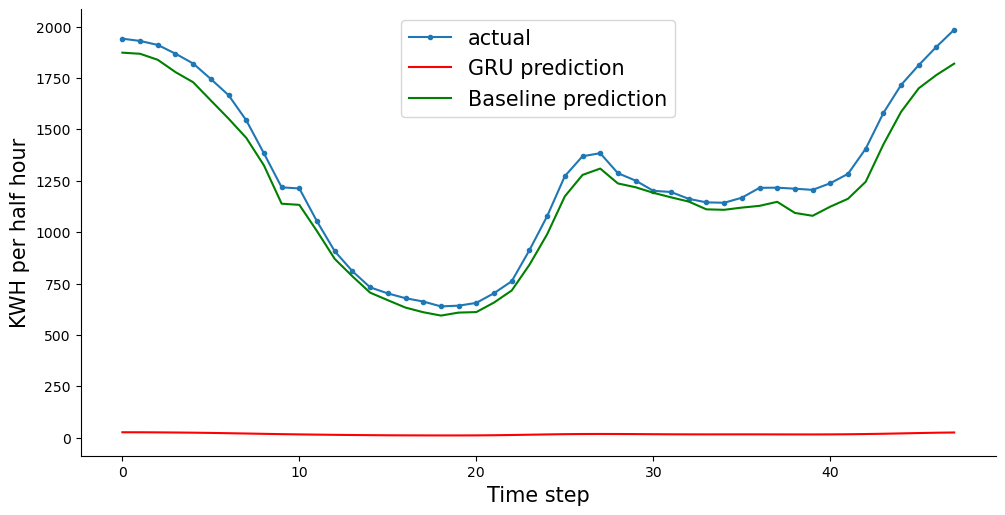

<Figure size 640x480 with 0 Axes>

In [125]:
len_prediction=[x for x in range(len(testYhat[0,:,-1]))]
plt.figure(figsize=(10,5))
# plt.plot(len_prediction, test_data[:OUT_STEPS].AggregateLoad, marker='.', label="actual")
plt.plot(len_prediction, mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], marker='.', label="actual")
plt.plot(len_prediction, testYhat[0,:,-1], 'r', label="GRU prediction")
plt.plot(len_prediction, NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS], 'g', label="Baseline prediction")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('KWH per half hour', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()
plt.savefig('Test First Day.png', format='png')

## Aggregate results for Test period: Benchmark, GRU model and actuals

In [126]:
# build dataset for the test dataset

ds = tf.keras.utils.timeseries_dataset_from_array(
      data=test_data,
      targets=None,
      sequence_length=IN_STEPS,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

# get the prediction
testYhatNormed = multi_gru_model.predict(ds)

122/122 [==============================] - 2s 13ms/step


In [127]:
print(testYhatNormed.shape)
print(testYhatNormed)

(3876, 48, 1)
[[[2.1565008 ]
  [2.144886  ]
  [2.0707743 ]
  ...
  [1.5358742 ]
  [1.7932434 ]
  [1.9781109 ]]

 [[2.123849  ]
  [2.0498524 ]
  [1.9431542 ]
  ...
  [1.8016855 ]
  [1.9696611 ]
  [2.04805   ]]

 [[2.0722094 ]
  [1.9622757 ]
  [1.8246586 ]
  ...
  [1.9761198 ]
  [2.0430098 ]
  [2.0381298 ]]

 ...

 [[0.2991745 ]
  [0.30101338]
  [0.34217846]
  ...
  [0.2228646 ]
  [0.1211977 ]
  [0.0821989 ]]

 [[0.3278768 ]
  [0.31454644]
  [0.32533062]
  ...
  [0.15844795]
  [0.10588668]
  [0.10606863]]

 [[0.3509544 ]
  [0.31898075]
  [0.30089062]
  ...
  [0.16061679]
  [0.15547085]
  [0.17876032]]]


In [128]:
# Invert standardization
testYhat = testYhatNormed * train_std.AggregateLoad + train_mean.AggregateLoad

print(testYhat.shape)
print(testYhat)

(3876, 48, 1)
[[[2019.6614 ]
  [2013.2703 ]
  [1972.4907 ]
  ...
  [1678.1654 ]
  [1819.7811 ]
  [1921.5034 ]]

 [[2001.6948 ]
  [1960.9785 ]
  [1902.2686 ]
  ...
  [1824.4263 ]
  [1916.854  ]
  [1959.9868 ]]

 [[1973.2805 ]
  [1912.79   ]
  [1837.0671 ]
  ...
  [1920.4077 ]
  [1957.2136 ]
  [1954.5283 ]]

 ...

 [[ 997.67914]
  [ 998.691  ]
  [1021.3418 ]
  ...
  [ 955.69006]
  [ 899.74854]
  [ 878.2897 ]]

 [[1013.4724 ]
  [1006.13745]
  [1012.07135]
  ...
  [ 920.24524]
  [ 891.3237 ]
  [ 891.4238 ]]

 [[1026.1707 ]
  [1008.5774 ]
  [ 998.6234 ]
  ...
  [ 921.4386 ]
  [ 918.6071 ]
  [ 931.422  ]]]


# Estimate financial impact of improved forecast

## Load pricing data

Load day forward and real time wholesale electricity pricing data to help us estimate financial benefit of the best model.

In [129]:
prices = pd.read_csv('/kaggle/input/new-england-locational-marginal-pricing-elec/New England Elec prices.csv', parse_dates=["Date"])
prices

Date  Hour Ending  Location ID     Location Name Location Type  \
0  2023-10-02            1         4013  .I.HQHIGATE120 2     EXT. NODE   
1  2023-10-02            2         4013  .I.HQHIGATE120 2     EXT. NODE   
2  2023-10-02            3         4013  .I.HQHIGATE120 2     EXT. NODE   
3  2023-10-02            4         4013  .I.HQHIGATE120 2     EXT. NODE   
4  2023-10-02            5         4013  .I.HQHIGATE120 2     EXT. NODE   
5  2023-10-02            6         4013  .I.HQHIGATE120 2     EXT. NODE   
6  2023-10-02            7         4013  .I.HQHIGATE120 2     EXT. NODE   
7  2023-10-02            8         4013  .I.HQHIGATE120 2     EXT. NODE   
8  2023-10-02            9         4013  .I.HQHIGATE120 2     EXT. NODE   
9  2023-10-02           10         4013  .I.HQHIGATE120 2     EXT. NODE   
10 2023-10-02           11         4013  .I.HQHIGATE120 2     EXT. NODE   
11 2023-10-02           12         4013  .I.HQHIGATE120 2     EXT. NODE   
12 2023-10-02           13         4013  .I.HQHIGATE120 2     EXT. NODE   
13 2023-10-02           14         4013  .I.HQHIGATE120 2     EXT. NODE   
14 2023-10-02           15         4013  .I.HQHIGATE120 2     EXT. NODE   
15 2023-10-02           16         4013  .I.HQHIGATE120 2     EXT. NODE   
16 2023-10-02           17         4013  .I.HQHIGATE120 2     EXT. NODE   
17 2023-10-02           18         4013  .I.HQHIGATE120 2     EXT. NODE   
18 2023-10-02           19         4013  .I.HQHIGATE120 2     EXT. NODE   
19 2023-10-02           20         4013  .I.HQHIGATE120 2     EXT. NODE   
20 2023-10-02           21         4013  .I.HQHIGATE120 2     EXT. NODE   
21 2023-10-02           22         4013  .I.HQHIGATE120 2     EXT. NODE   
22 2023-10-02           23         4013  .I.HQHIGATE120 2     EXT. NODE   
23 2023-10-02           24         4013  .I.HQHIGATE120 2     EXT. NODE   

    Real Time Locational Marginal Price  Energy Component  \
0                                 19.72             19.58   
1                                 14.60             14.54   
2                                 14.39             14.35   
3                                 14.54             14.44   
4                                 13.73             13.63   
5                                 10.47             10.96   
6                                 18.71             20.08   
7                                 22.17             23.73   
8                                 12.84             13.78   
9                                 12.40             12.78   
10                                16.52             16.54   
11                                17.46             17.44   
12                                16.53             16.53   
13                                12.95             13.55   
14                                16.57             17.01   
15                                17.72             18.34   
16                                20.13             21.66   
17                                35.75             38.34   
18                                37.99             40.61   
19                                23.86             25.57   
20                                21.37             22.78   
21                                17.21             18.38   
22                                14.20             14.73   
23                                12.76             12.87   

    Congestion Component  Marginal Loss Component  \
0                   0.00                     0.14   
1                   0.00                     0.06   
2                   0.00                     0.04   
3                   0.00                     0.10   
4                   0.00                     0.10   
5                   0.00                    -0.49   
6                   0.00                    -1.37   
7                   0.00                    -1.56   
8                   0.00                    -0.94   
9                   0.00                    -0.38   
10                  0.00

## Visualize pricing curve

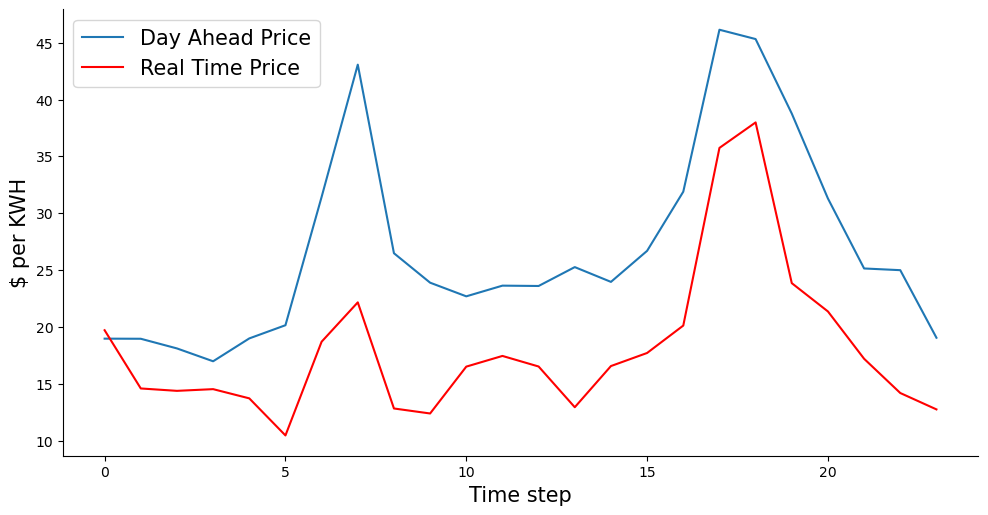

<Figure size 640x480 with 0 Axes>

In [130]:
# Plot Naive prediction, GRU prediction and Actuals for first 24 hours of the test set (normed values)
len_prediction=[x for x in range(len(prices['Date']))]
plt.figure(figsize=(10,5))
# plt.plot(len_prediction, test_data[:OUT_STEPS].AggregateLoad, marker='.', label="actual")
plt.plot(len_prediction, prices['Day Ahead Locational Marginal Price'], label="Day Ahead Price")
plt.plot(len_prediction, prices['Real Time Locational Marginal Price'], 'r', label="Real Time Price")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('$ per KWH', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();
plt.savefig('Price Curve.png', format='png')

The average offer price for “balancing actions” – to align supply and demand – between the start of September and early January was £287 a MWh. Data from Elexon, which oversees the market, shows Rye House submitted the 20 highest winter bids – between £5,000 and £6,000 a MWh – for varying volumes of power on 12 December, setting new records
https://www.theguardian.com/business/2023/jan/29/gas-fired-plants-uk-lights-on-cost-profits-energy-crisis

## Calculate baseline estimate overestimate and underestimate profile




In [131]:
import math

def calculate_forecast_penalty(forecast, actual, prices):
    # forecast is a list of 48 half-hourly forecast values
    # actual is a list of 48 half-hourly actual values
    # prices is a dataframe with 24 day-ahead and real-time wholesale electricity prices

    baselineMisEstDollars = []
    dollarPenalty = 0
    counter = 0

    misEstimate = forecast - actual
    
    for x in misEstimate:
        priceIndex = math.floor(counter / 2) # we only have hourly pricing data
        # print('priceIndex: ', priceIndex)
        if x > 0:
            # overestimate
            dollarPenalty = x * prices.iloc[priceIndex]['Day Ahead Locational Marginal Price']
        elif x < 0:
            # underestimate
            dollarPenalty = x * (prices.iloc[priceIndex]['Real Time Locational Marginal Price'] - prices.iloc[priceIndex]['Day Ahead Locational Marginal Price'])
        else:
            dollarPenalty = 0
        baselineMisEstDollars.append(dollarPenalty)
        counter += 1

    print('\nDollar penalty for misestimation each half-hour: ', baselineMisEstDollars)
    TotalDollarPenalty = sum(baselineMisEstDollars)
    print('\nTotal dollar penalty for misestimation for the day: ', TotalDollarPenalty)
    return TotalDollarPenalty
    

In [132]:
baselinePenalty = calculate_forecast_penalty(forecast=NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS], 
                           actual=mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], 
                           prices=prices)
baselinePenalty


Dollar penalty for misestimation each half-hour:  [-50.34116160942092, -46.2058749951768, 316.2881300333435, 391.8405459322398, 340.06565009166417, 389.6164056072542, 279.21592380968343, 209.4543473436643, 308.56090154468774, 419.3883921046357, 773.7549993866403, 460.15544715433555, 476.8988536180792, 316.65788158692925, 540.688566730239, 691.0501571232782, 623.490159854315, 709.2849767152485, 514.2869600874423, 387.7907972759563, 276.23533432195086, 281.5718699180546, 277.3881105701589, 439.70344045826414, 623.4332147685766, 696.3651237427534, 1120.9816831458481, 920.7892794945897, 367.9872403752438, 240.1013075571826, 87.507751995906, 232.39660625090548, 156.42885194557158, 399.19236505660064, 356.14535262891764, 499.4973981212299, 642.4703832894868, 504.0881658546029, 1759.2334428795818, 1880.6324082702508, 1131.3156726841403, 1203.574115495551, 1276.5307619884875, 1215.7126269006026, 1412.9499953961374, 1217.77543401302, 865.0987971207794, 1039.5223828772907]

Total dollar penalty

29176.57117651672

In [133]:
modelPenalty = calculate_forecast_penalty(forecast=testYhat[0,:,-1], 
                           actual=mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], 
                           prices=prices)
modelPenalty


Dollar penalty for misestimation each half-hour:  [1482.5858593671567, 1569.6564899445652, 1163.8023285379406, 794.1774614087561, 230.27950229890786, 50.13022807318814, 154.84444643258655, 185.84998468182894, 286.78528481013495, 108.6222035750587, 1242.6433069994055, 656.2208169314541, 158.82555954588943, 130.92227153119953, 1007.27705361674, 103.20317030265613, 181.480279037449, 249.0193259841751, 94.8513121811328, 147.24963821032398, 0.33290020602988535, 352.37079727993415, 1359.1105944694182, 816.9683841801058, 12.218006859380763, 608.3889166017821, 1483.7479591610822, 1382.4360536957138, 234.3226777554474, 229.38669662806154, 285.70918107759945, 622.7944086859765, 697.4610699652004, 639.1121480498146, 449.70089108525656, 660.0425174142415, 842.5389145145695, 970.6649268922399, 2044.4864417689198, 2034.0920312037988, 1452.0247676747874, 1370.6223978309185, 1294.3548815213985, 1716.1084264870499, 2157.1132834918617, 1456.9564498644108, 521.1482545128667, 401.0513456331015]

Total do

36093.691847981514

In [134]:
print('\nBaseline penalty: ${:,.2f}'.format(baselinePenalty))
print('Model penalty: ${:,.2f}'.format(modelPenalty))


Baseline penalty: $29,176.57
Model penalty: $36,093.69


In [135]:
# Area Under Curve
from scipy.integrate import simpson
from numpy import trapz

# The y values.  A numpy array is used here,
# but a python list could also be used.
# y = np.array([5, 20, 4, 18, 19, 18, 7, 4])
yhat = NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS]

print(NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS])
print(yhat)

# Compute the area using the composite trapezoidal rule.
yhatArea = trapz(yhat, dx=5)
# print("yhat area =", yhatArea)

# Compute the area using the composite Simpson's rule.
yhatArea = simpson(yhat, dx=5)
# print("yhat area =", yhatArea)

yActual = mergeData.AggregateLoad[train_size+test_size:train_size+test_size+OUT_STEPS]

# Compute the area using the composite trapezoidal rule.
yActualArea = trapz(yActual, dx=5)
print("yActualArea trapz =", yActualArea)

# Compute the area using the composite Simpson's rule.
yActualArea = simpson(yActual, dx=5)
print("yActualArea simpson =", yActualArea)

# Calculate the area difference between the two curves...
AreaDifference = yhatArea - yActualArea
print("AreaDifference =", AreaDifference)

# calculate price at £287 a MWh
cost = (AreaDifference / 1000) * 287
print("cost for 1 day for 5k homes =", cost)


35300    1873.519721
35301    1868.129339
35302    1838.763954
35303    1778.999573
35304    1729.623688
35305    1640.771804
35306    1552.609423
35307    1458.898037
35308    1324.783654
35309    1138.497270
35310    1132.822236
35311    1004.540242
35312     869.710597
35313     784.941953
35314     705.532308
35315     668.758665
35316     632.808021
35317     610.352377
35318     593.971732
35319     608.525089
35320     611.015444
35321     657.400618
35322     716.200292
35323     841.127966
35324     989.442141
35325    1174.164314
35326    1278.474489
35327    1309.488663
35328    1237.067837
35329    1218.482011
35330    1191.508684
35331    1169.470359
35332    1148.832532
35333    1111.011206
35334    1108.764881
35335    1119.497054
35336    1127.987228
35337    1147.653403
35338    1093.525577
35339    1079.631751
35340    1124.160758
35341    1162.481766
35342    1245.164773
35343    1426.776780
35344    1585.652787
35345    1700.311796
35346    1765.185804
35347    1820

The population of England was 56,489,800 in 2021
24.9 million dwellings in England



In [136]:
# Scale up costs
cost = cost * (56000000/5000)
print("cost for 1 day for 5k homes =", cost)

cost for 1 day for 5k homes = 109609316.96170095


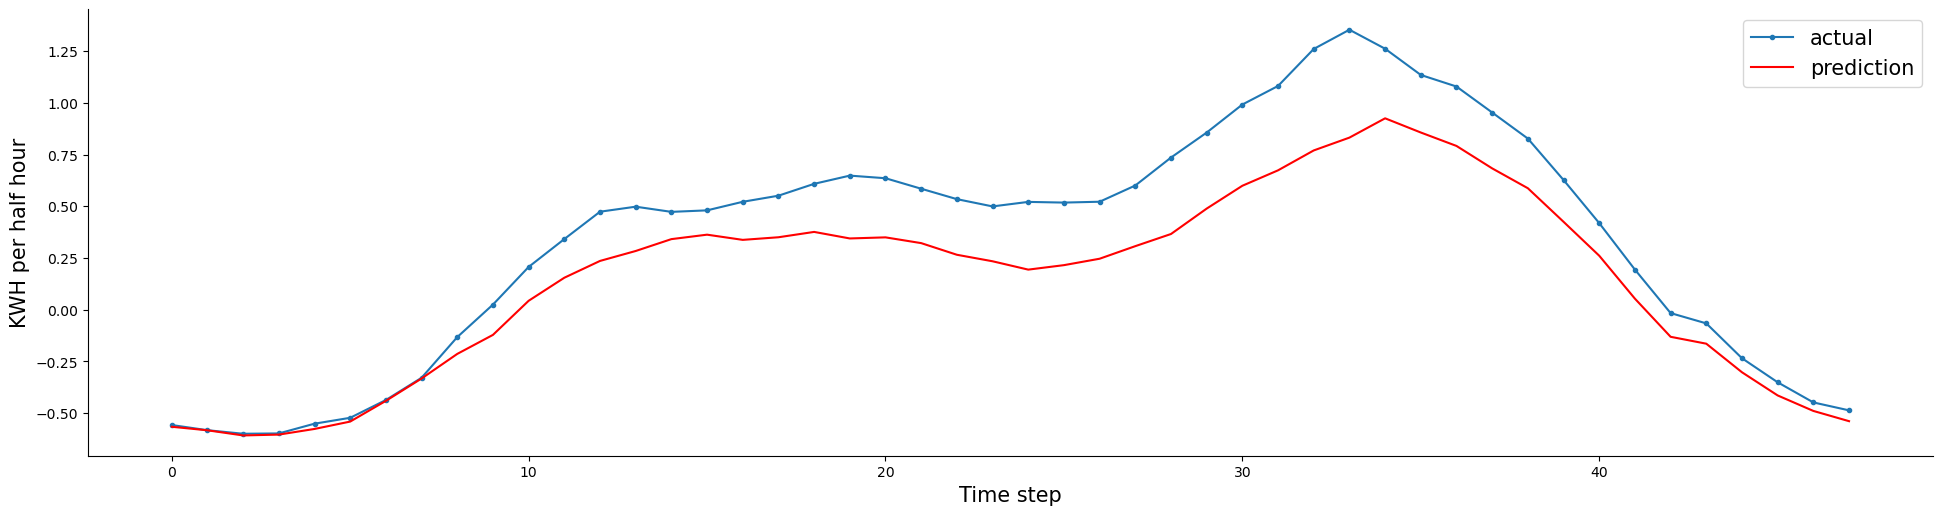

In [137]:
# visualize naive forecast and actuals for first day of the test dataset
mergeDataNormed = (mergeData - train_mean) / train_std
prediction_plot(mergeDataNormed.AggregateLoad[train_size+test_size:train_size+test_size+OUT_STEPS], NaiveForecastNormed.AggregateLoad[train_size+test_size:train_size+test_size+OUT_STEPS])

In [138]:
print(mergeDataNormed.AggregateLoad[train_size:train_size+val_size])
print(NaiveForecastNormed.AggregateLoad[train_size:train_size+val_size])


27456    0.260587
27457    0.226205
27458    0.178946
27459    0.176955
27460    0.176203
           ...   
35295    1.084425
35296    1.447238
35297    1.649956
35298    1.801309
35299    1.941808
Name: AggregateLoad, Length: 7844, dtype: float64
27456    0.210437
27457    0.219524
27458    0.195366
27459    0.132948
27460    0.143211
           ...   
35295    1.230590
35296    1.464227
35297    1.666427
35298    1.764818
35299    1.822603
Name: AggregateLoad, Length: 7844, dtype: float64
